# Purely horizontal modes

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import yt
##yt.mylog.setLevel()
yt.utilities.logger.disable_stream_logging()

In [2]:
dataDir = "../oldruns/fri14/kv0"

## Input deck

summary of important things

* closed bc
* $k_H = 8$
* $k_v = 0$
* $A = 0.01$

```bash
# INITIAL MODEL
maestro.perturb_model = false

maestro.ppm_type = 0
maestro.max_step  = 1000
maestro.stop_time = 1e4

# PROBLEM SIZE
geometry.prob_lo     =  0.0  0.0  0.0
geometry.prob_hi     =  1.0e9  1.0e9  1.0e9

# PROBLEM SIZE & GEOMETRY
# 0 = Interior   3 = Symmetry
# 1 = Inflow     4 = Slipwall
# 2 = Outflow    5 = NoSlipWall
maestro.lo_bc = 0 4 4 
maestro.hi_bc = 0 4 4
geometry.is_periodic =  1 0 0

# VERBOSITY
maestro.v              = 1       # verbosity

# DEBUG FOR NAN
amrex.fpe_trap_invalid = 1       # floating point exception

# REFINEMENT
amr.n_cell           =  64 64 64 
amr.max_level       = 0       # maximum level number allowed
amr.ref_ratio       = 2 2 2 2 # refinement ratio
amr.blocking_factor = 8       # block factor in grid generation
amr.max_grid_size   = 128
maestro.regrid_int     = 2       # how often to regrid
amr.refine_grid_layout = 0       # chop grids up into smaller grids if nprocs > ngrids

maestro.regrid_int      = 2       # how often to regrid

# TIME STEP CONTROL
maestro.cfl         = 0.9    # cfl number for hyperbolic system
maestro.init_shrink = 0.1e0

# PLOTFILES
maestro.plot_base_name  = single_level/plt    # root name of plot file
maestro.plot_int   =  10     # number of timesteps between plot files
maestro.plot_deltat = 10e0  #0.1e0

maestro.small_plot_base_name  = tmpsingle_level/sml    # root name of plot file

# CHECKPOINT
maestro.check_base_name = single_level/chk
maestro.chk_int         = -1

# ALGORITHMIC OPTIONS
maestro.evolve_base_state = true
maestro.do_initial_projection = true
maestro.init_divu_iter        = 1
maestro.init_iter             = 1
maestro.do_reflux             = 0 # do we do the hyperbolic reflux

maestro.do_sponge = 0
maestro.sponge_center_density = 3.e6
maestro.sponge_start_factor = 10.e0
maestro.sponge_kappa = 10.e0

maestro.use_thermal_diffusion = false

# tolerances for the initial projection
maestro.eps_init_proj_cart = 1.e-12
maestro.eps_init_proj_sph  = 1.e-10
# tolerances for the divu iterations
maestro.eps_divu_cart      = 1.e-8
maestro.eps_divu_sph       = 1.e-10
maestro.divu_iter_factor   = 100.
maestro.divu_level_factor  = 10.
# tolerances for the MAC projection
#maestro.eps_mac            = 1.e-10
#maestro.eps_mac_max        = 1.e-8
#maestro.mac_level_factor   = 10.
#maestro.eps_mac_bottom     = 1.e-3
# tolerances for the nodal projection
maestro.eps_hg             = 1.e-12
maestro.eps_hg_max         = 1.e-10
maestro.hg_level_factor    = 10.
maestro.eps_hg_bottom      = 1.e-4

# HYDRODYNAMICS options
maestro.anelastic_cutoff_density = 1.e-10
maestro.base_cutoff_density = 1.e-10
maestro.grav_const = -3.0e4

# EOS parameters
maestro.small_temp = 1.e-10
maestro.small_dens = 1.e-10

# BURNING parameters
maestro.do_burning = false

# OMP settings
system.regtest_reduction = 1

&probin

  ! override the default values of the probin namelist values here
  pres_base = 1d13
  scale_height = 1d9
  pert_amp = 0.01
  k_hoz = 8.0d0
  k_vert = 0.0d0
  do_uniform = .false.
  do_isentropic = .false.
  use_p_dens_g = .false.
  use_p_h_g = .true.

  !extern

  ! Note that some of the parameters in this
  ! namelist are specific to the default EOS,
  ! network, and/or integrator used in the
  ! makefile. If you try a different set of
  ! microphysics routines be sure to check that
  ! the parameters in here are consistent, as
  ! Fortran does not like seeing unknown variables
  ! in the namelist.

  eos_gamma = 5.0d0/3.0d0
  eos_assume_neutral = T
  const_conductivity = 0.0d0

/
```

## initial condition

Initial condition on code was implemented as something like 

```Fortran
      rho_base = pres_base / scale_height / abs(grav_const)
      rho0 = s0_init(lev,r,rho_comp)
      rho_local = rho0 &
        + rho_base * pert_amp * exp(-y/(2d0 * scale_height)) * &
        cos(x * k_hoz * m_pi / (prob_hi(1) - prob_lo(1)) ) * &
        sin(y * k_vert * m_pi / (prob_hi(2) - prob_lo(2)) ) 
```

So found there was no pertubation ($\times sin 0 = 0$). Added following

```Fortran
      ! if k_vert is 0, dont multiply by sin(0) = 0
      ! (make this all more elegant later)
      
      if (k_vert == 0d0) then
        rho_local = rho0 &
          + rho_base * pert_amp * exp(-y/(2d0 * scale_height)) * &
          cos(x * k_hoz * m_pi / (prob_hi(1) - prob_lo(1)) )
      endif
```

In [3]:
ds = yt.load(dataDir+"/plt0000000/")


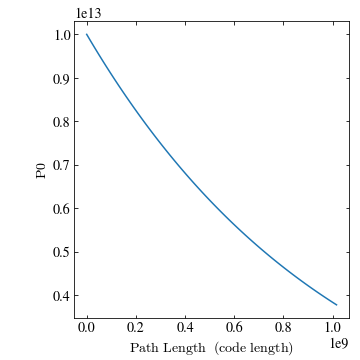

In [4]:
var = "p0"
plot = yt.LinePlot(ds,var,[0.,0.,0],[0.,1e9,0],64)
plot.set_log(var, False)


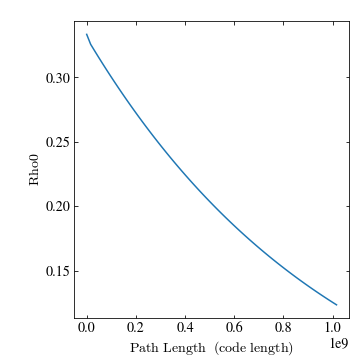

In [5]:
var = "rho0"
plot = yt.LinePlot(ds,var,[0,0,0],[0,1e9,0],64)
plot.set_log(var, False)


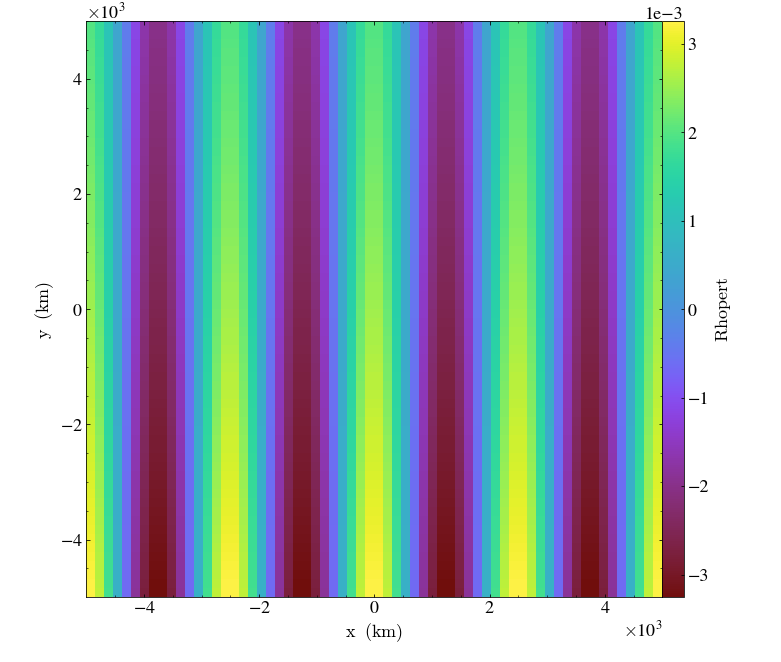

In [6]:
var = "rhopert";
plot = yt.SlicePlot(ds, "z", var);
plot.set_log(var, False);
plot

## Evolution of rhopert in time


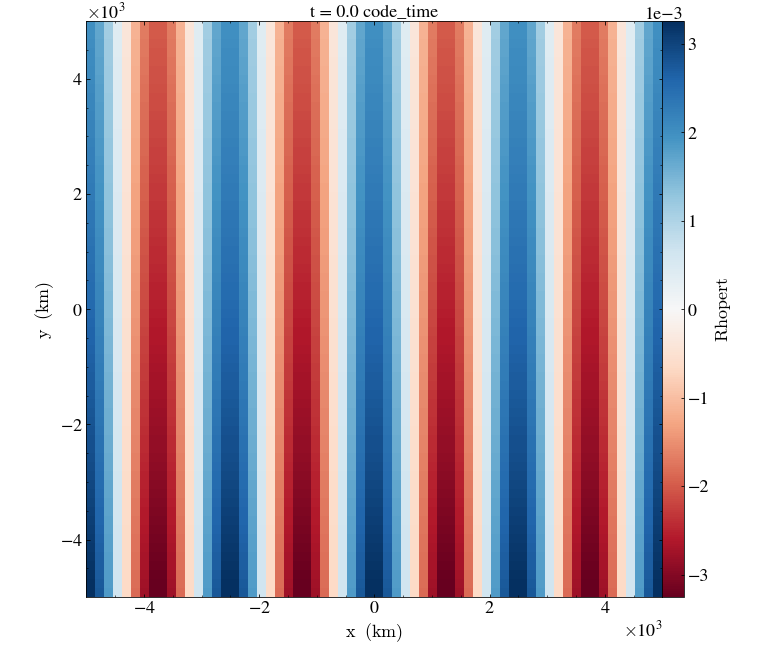


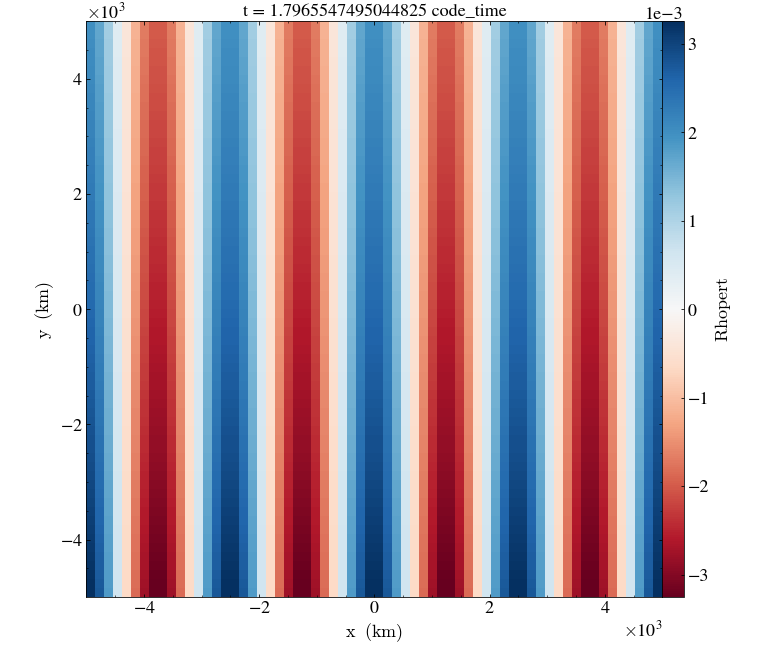


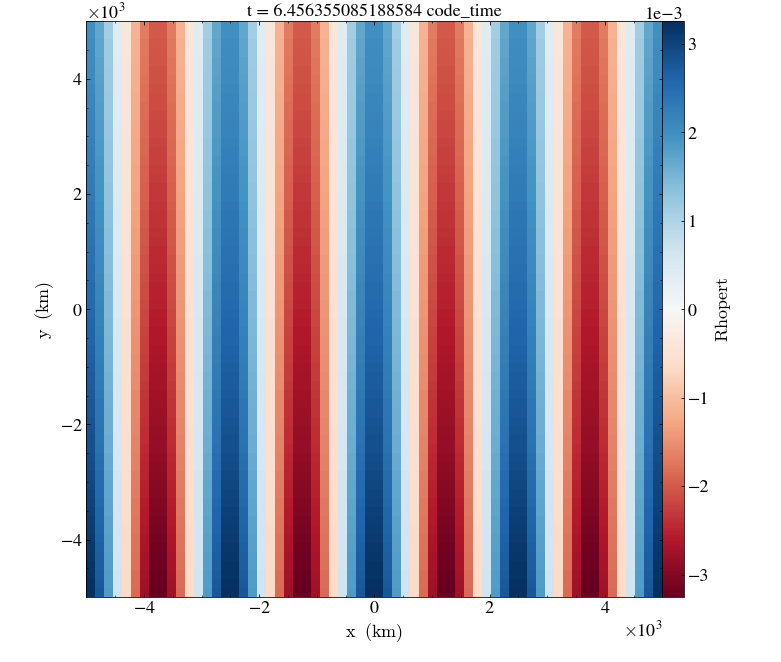


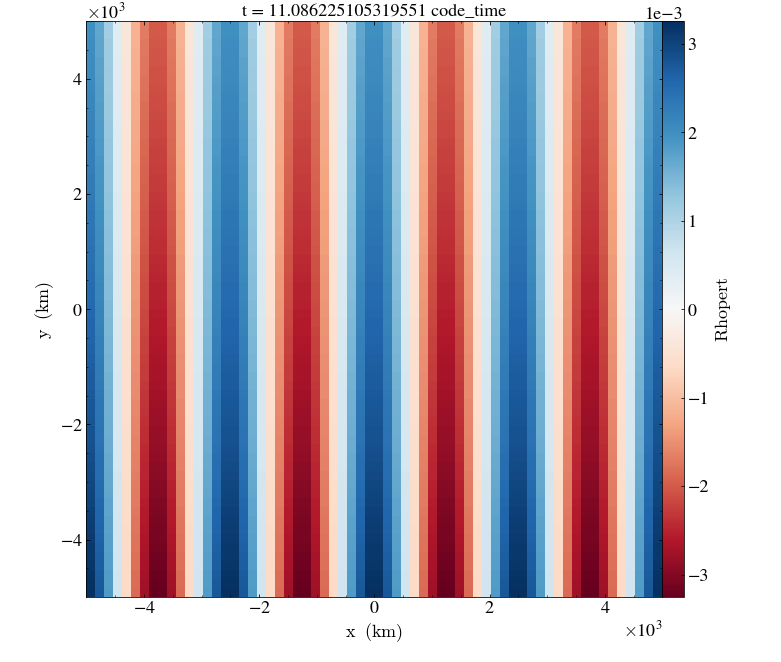


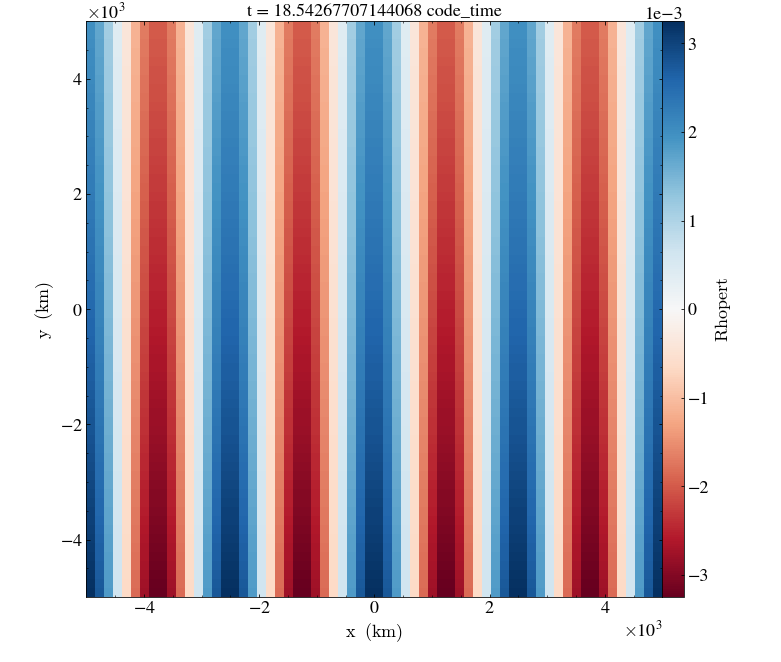


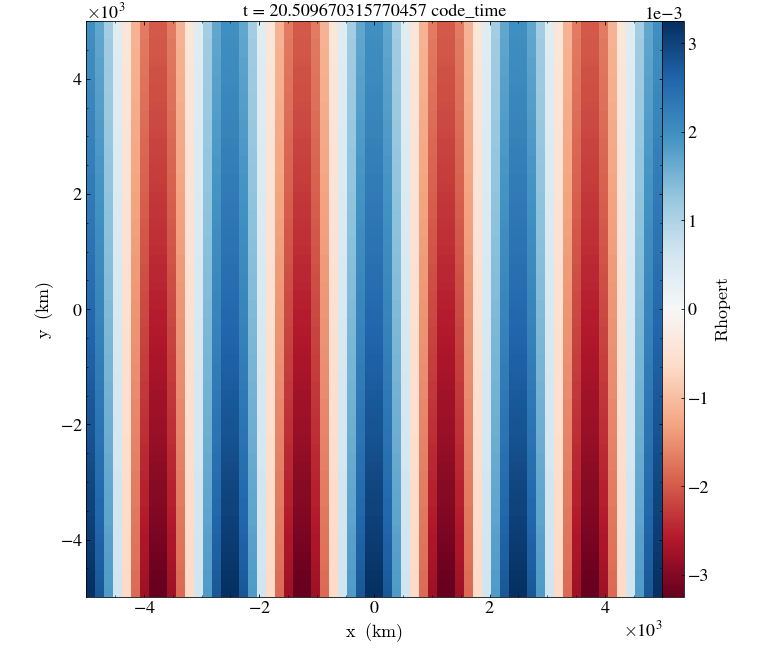


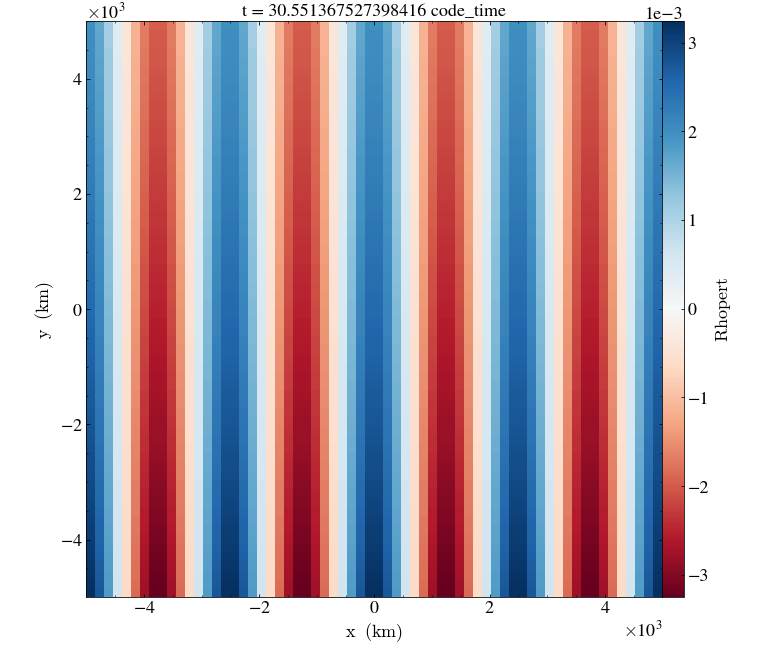


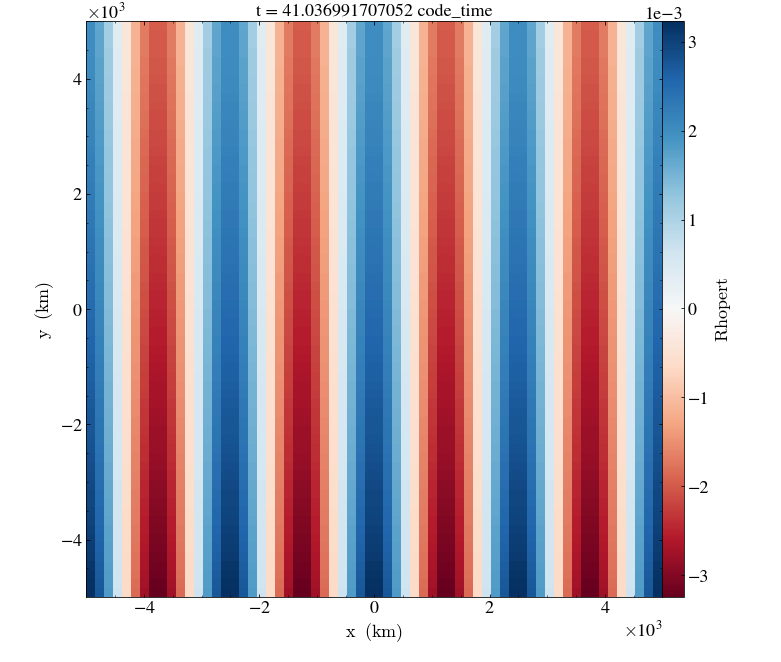


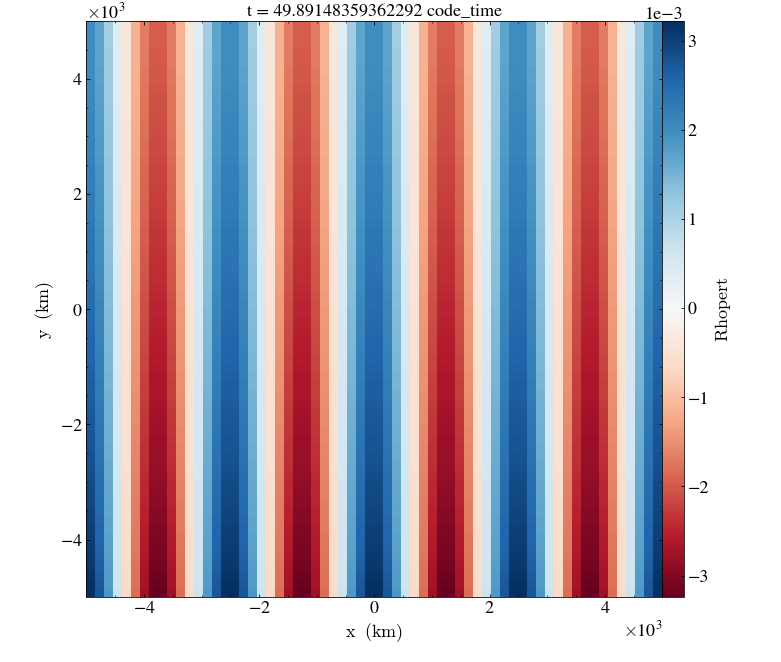


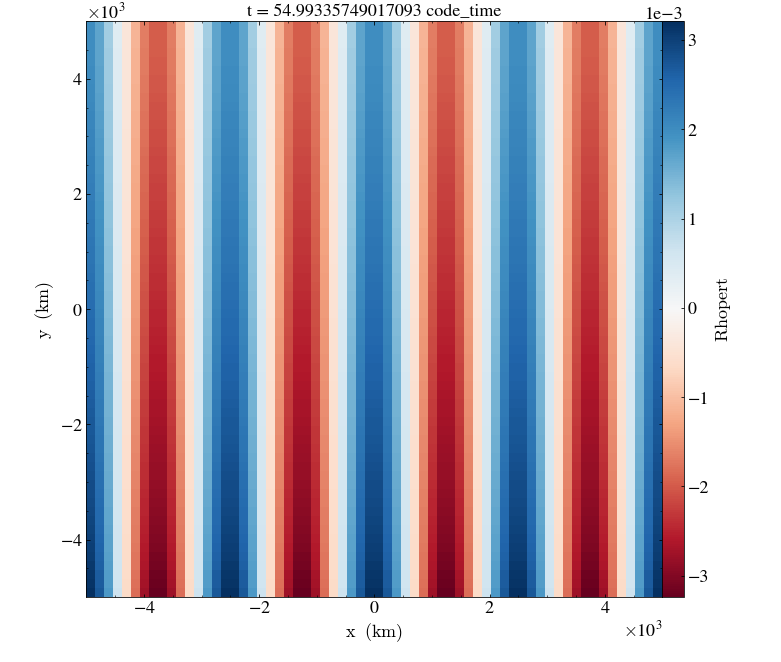


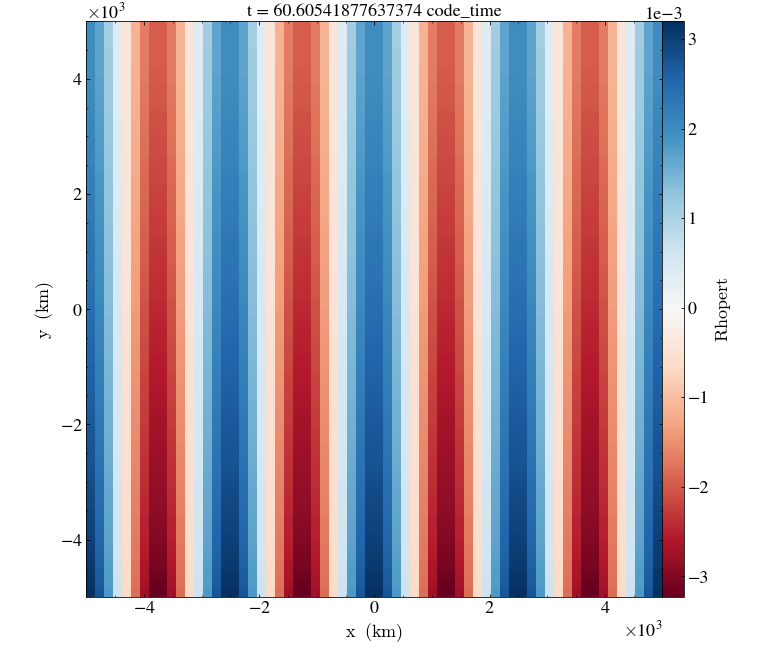


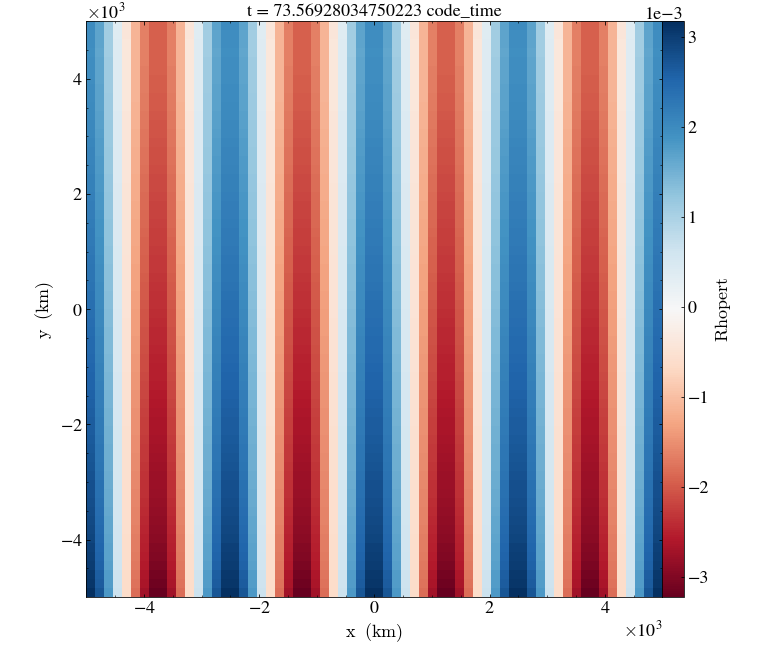


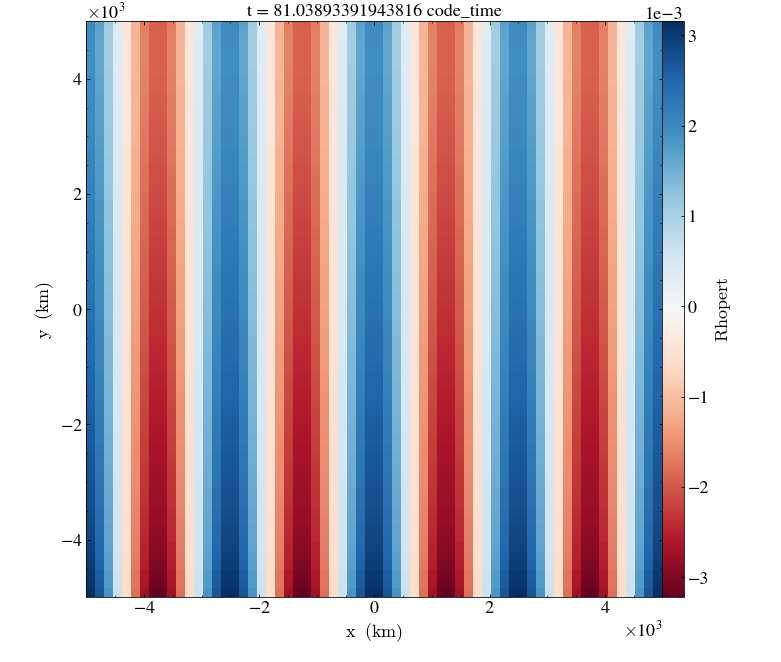


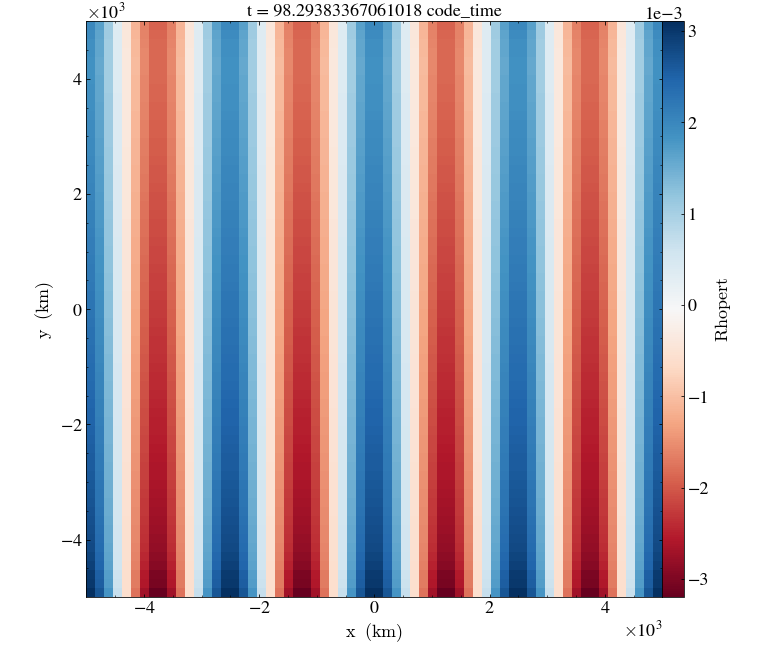


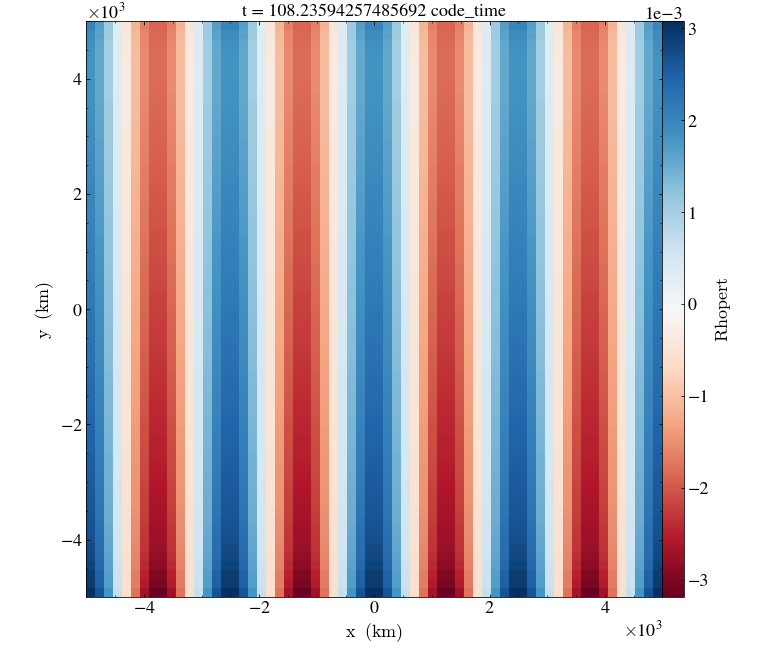


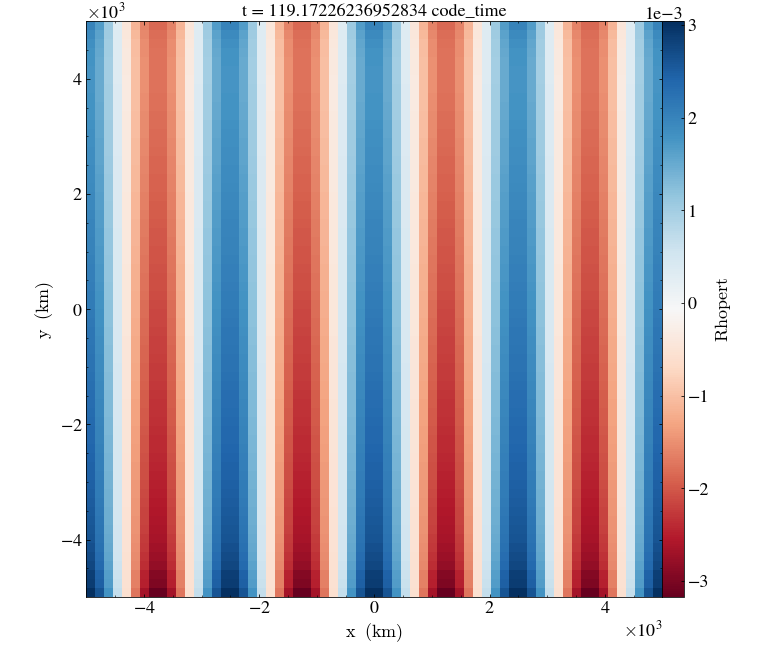


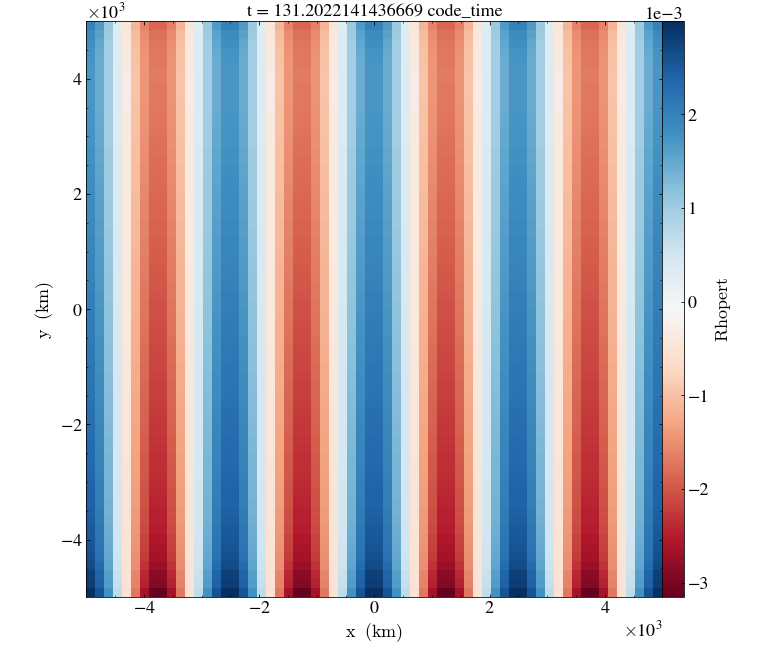


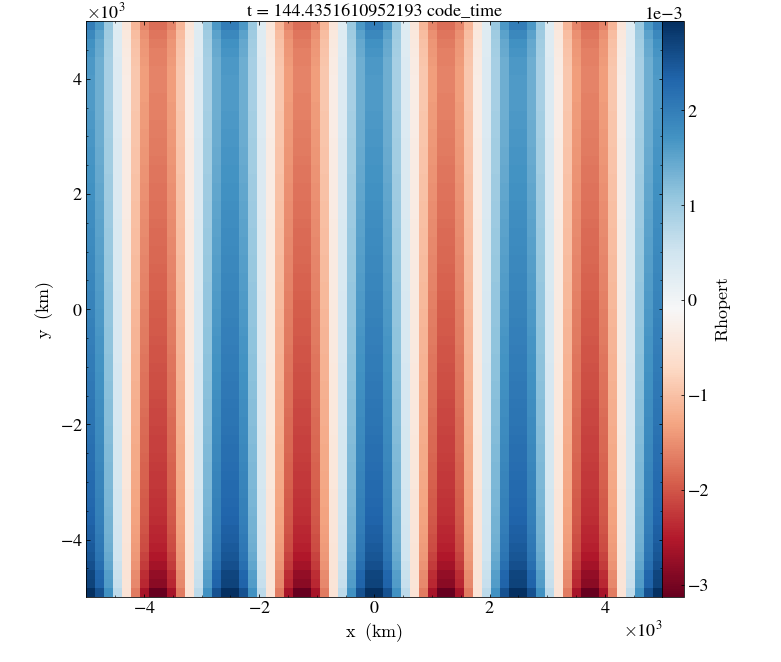


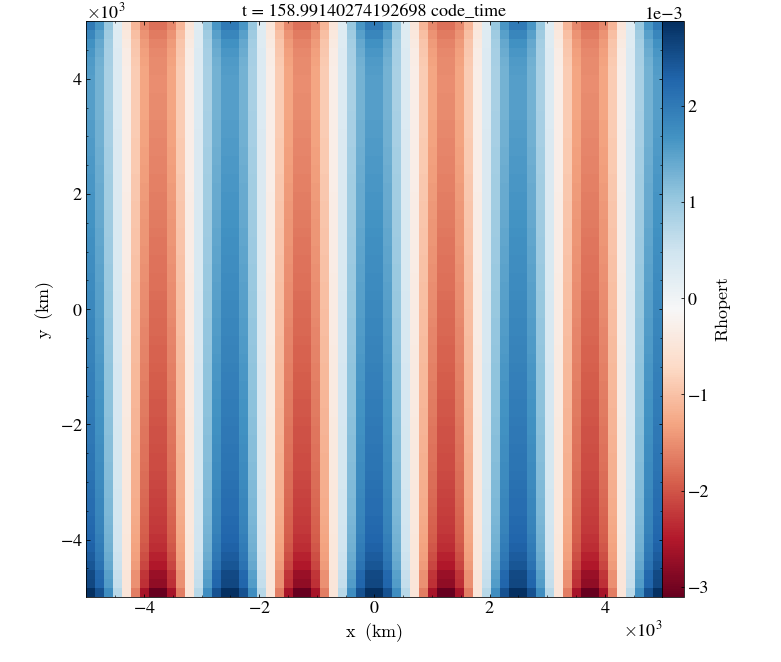


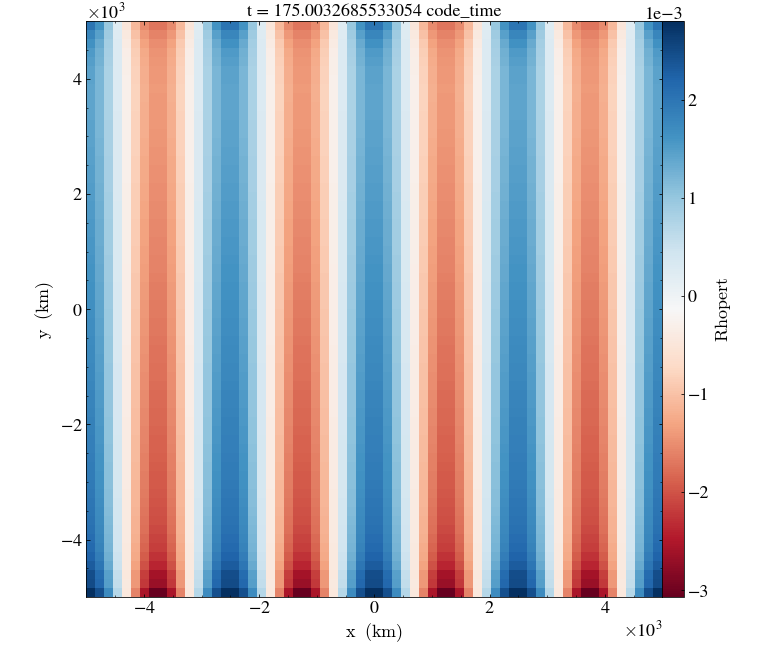


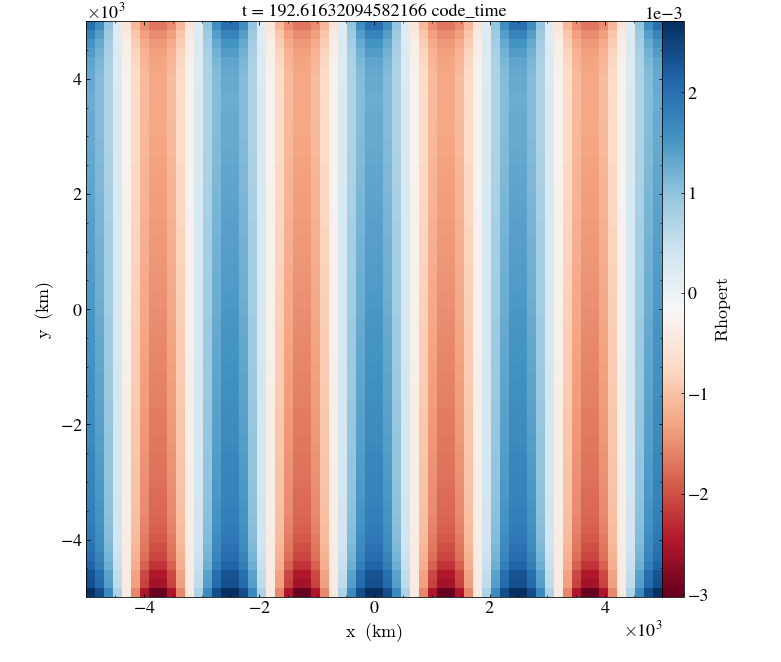


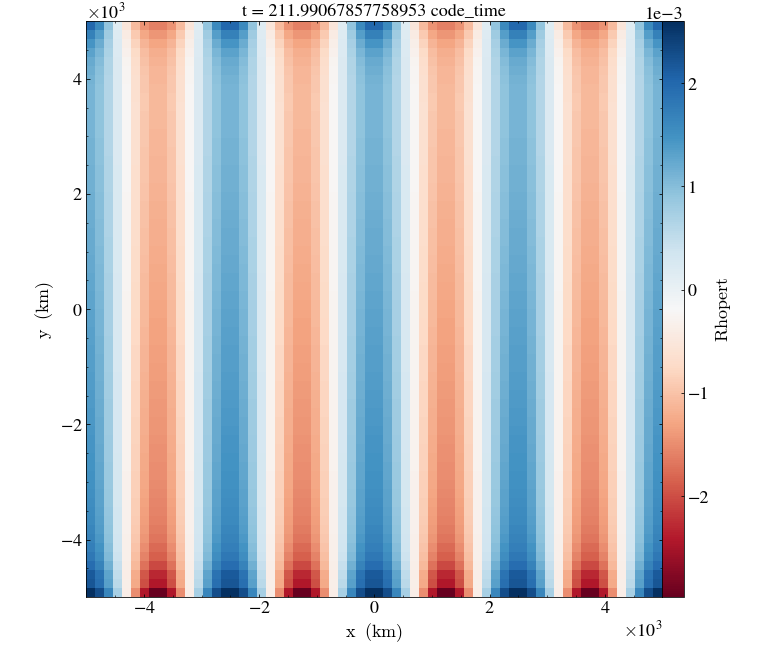


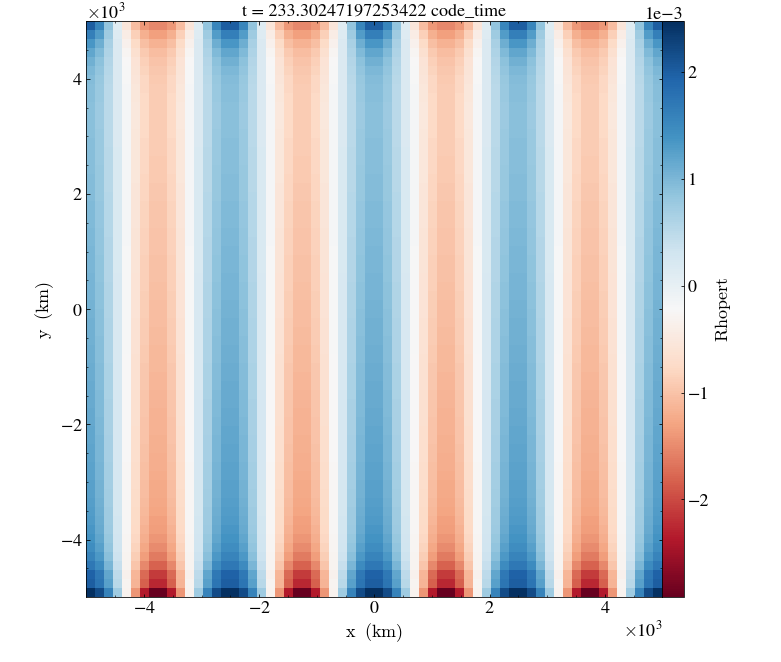


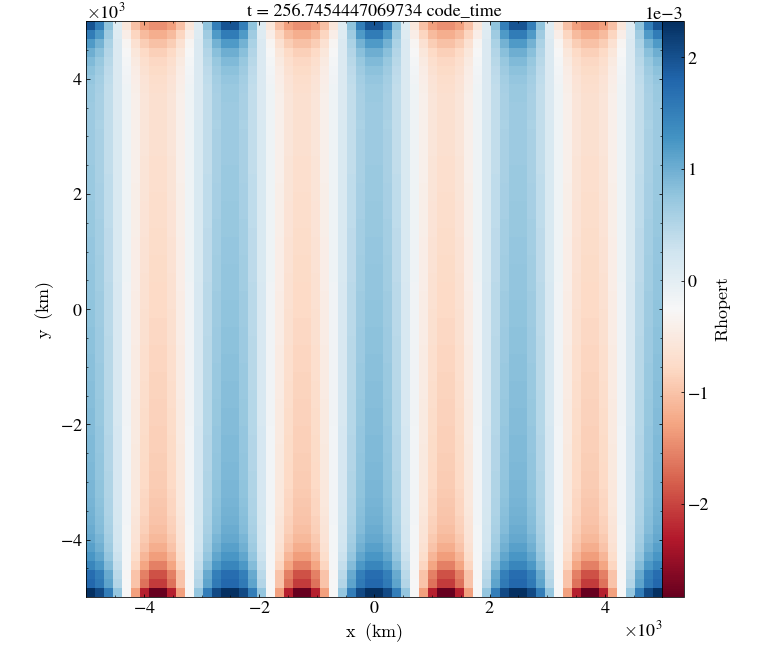


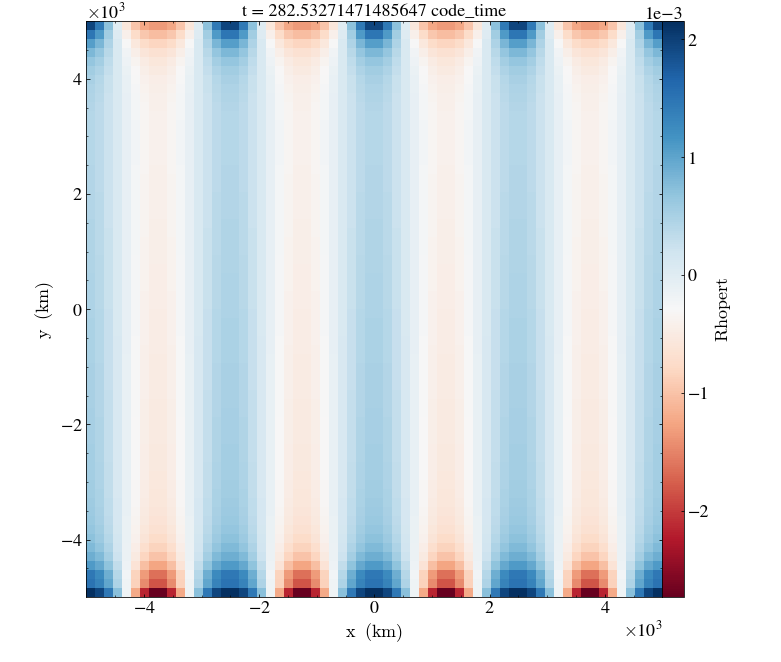


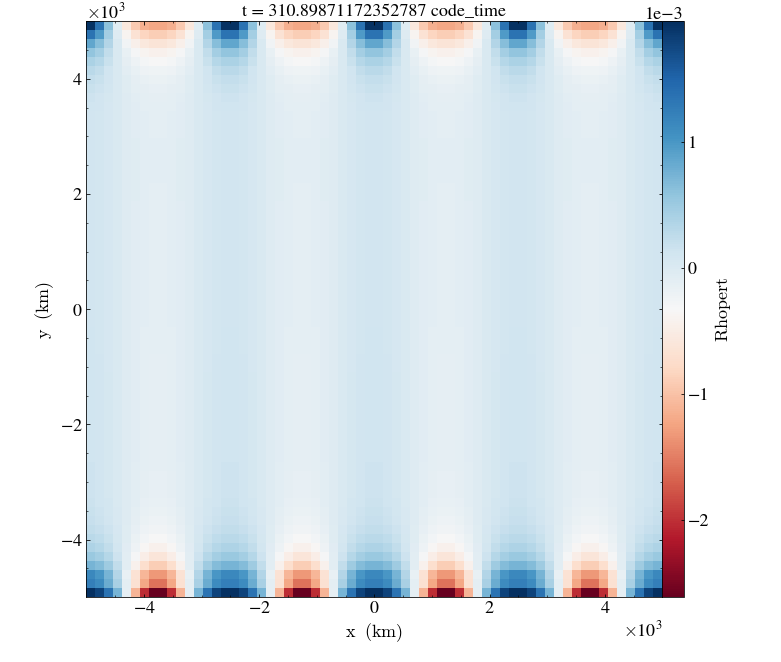


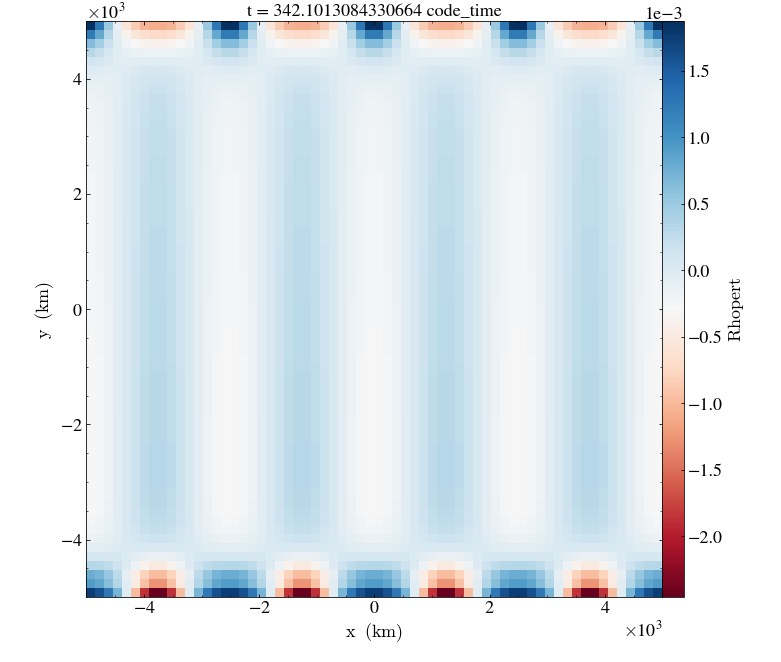


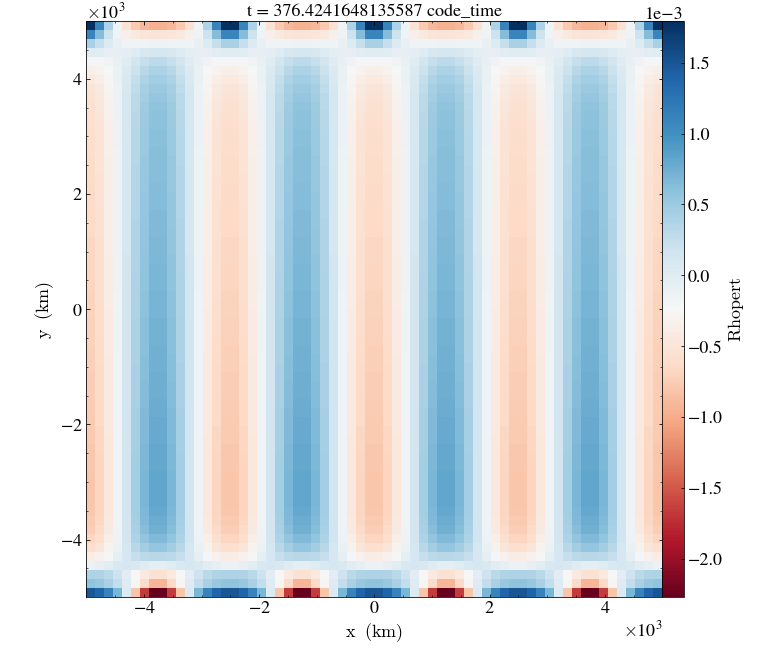


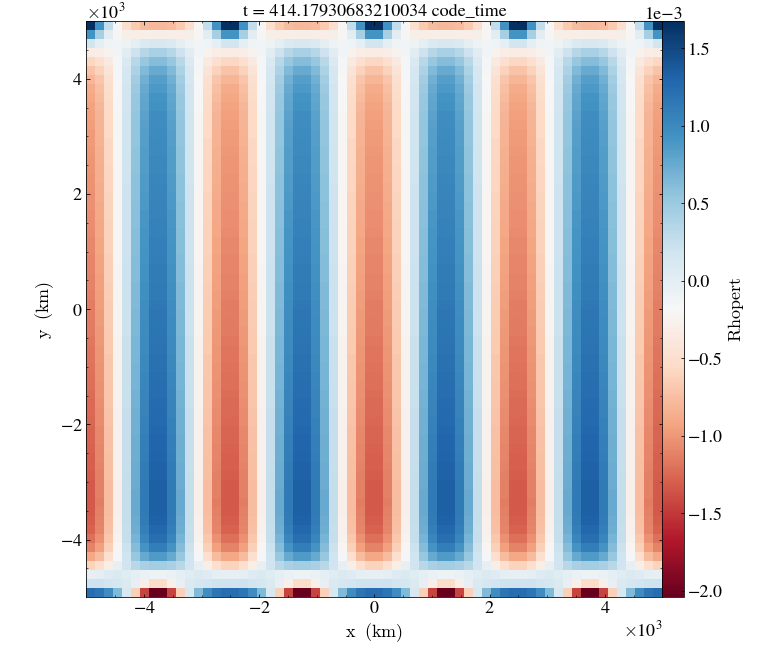


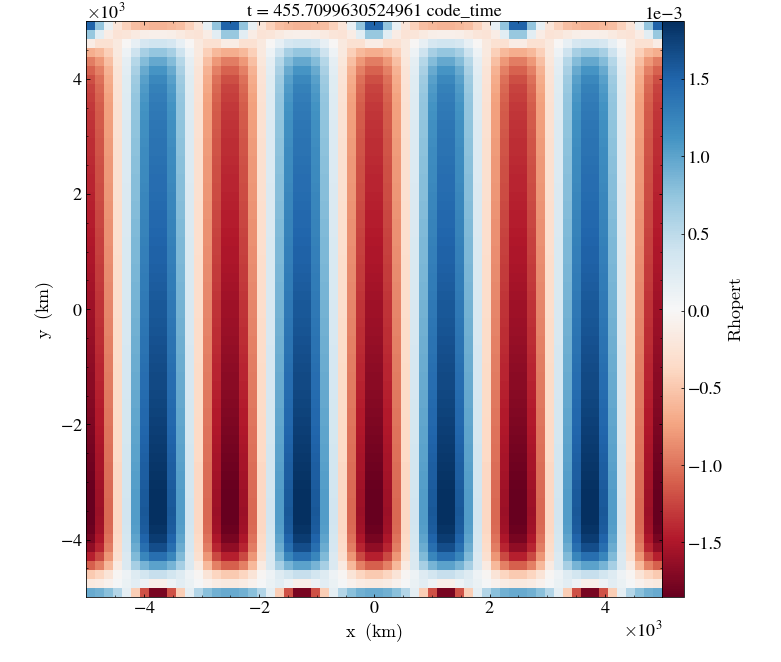


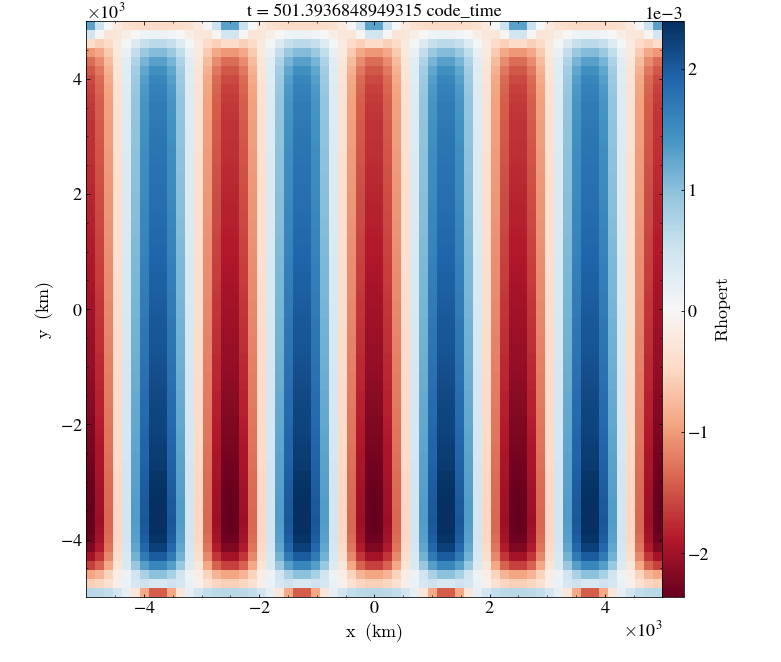


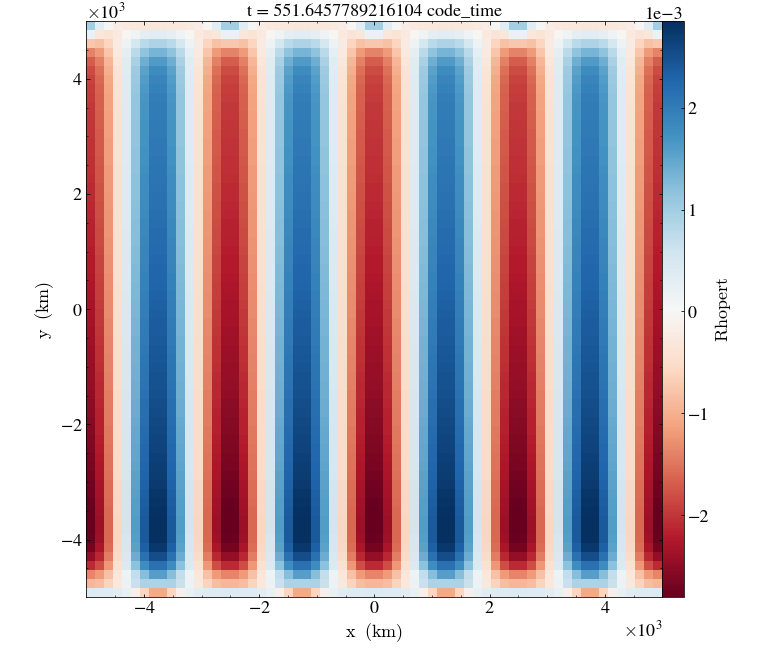


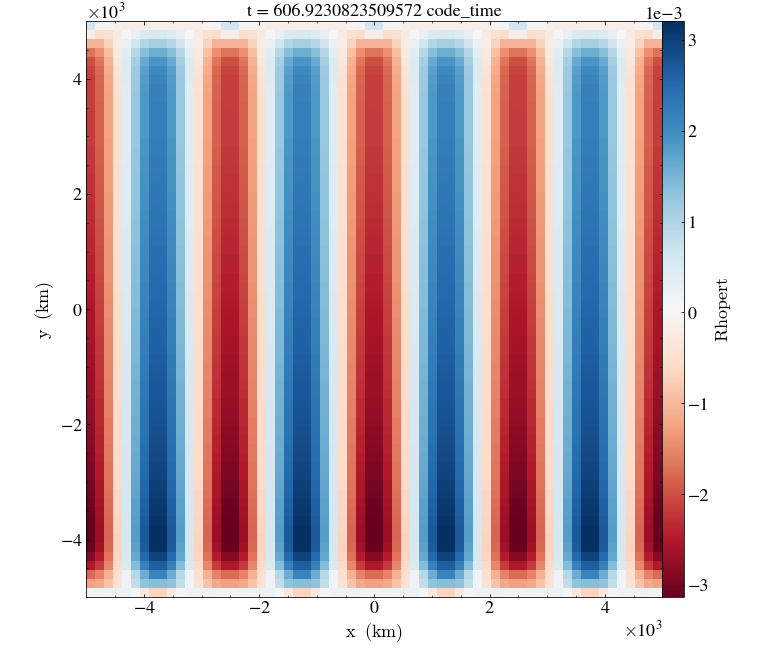


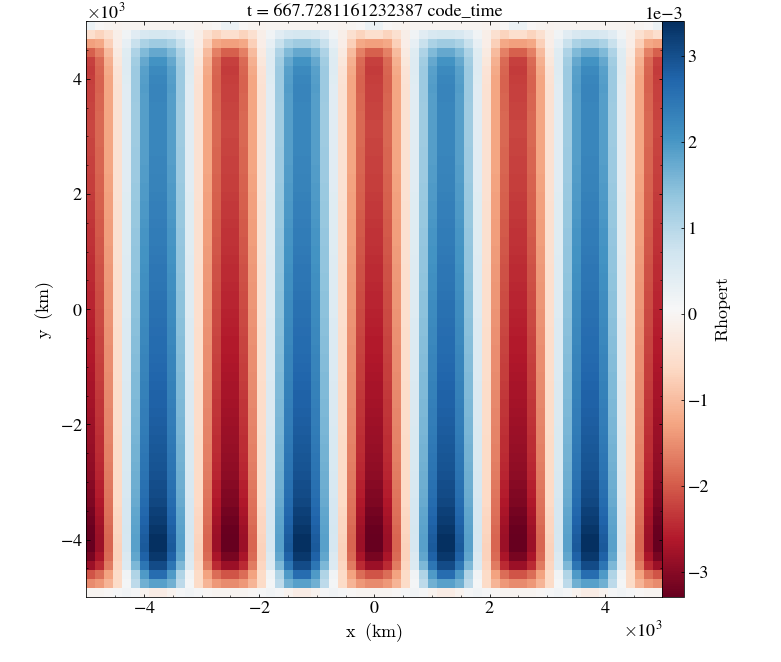


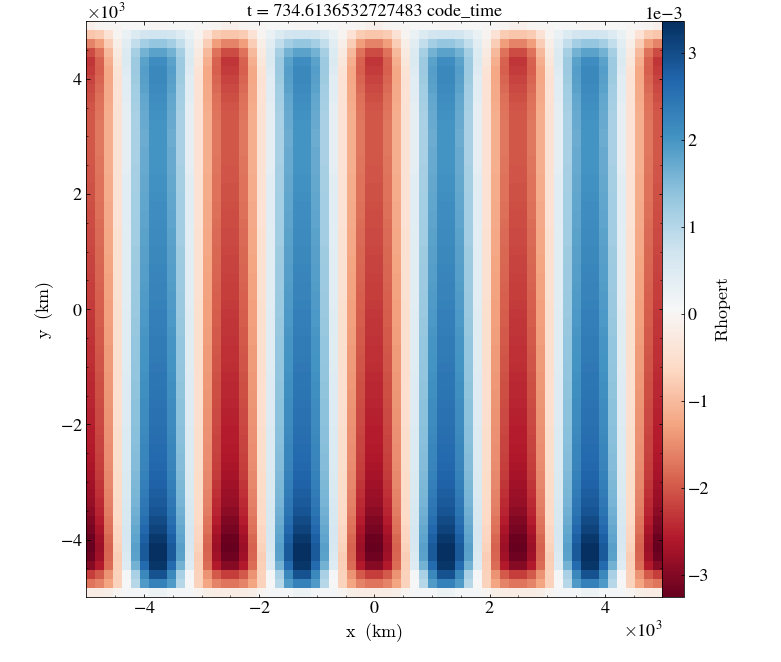


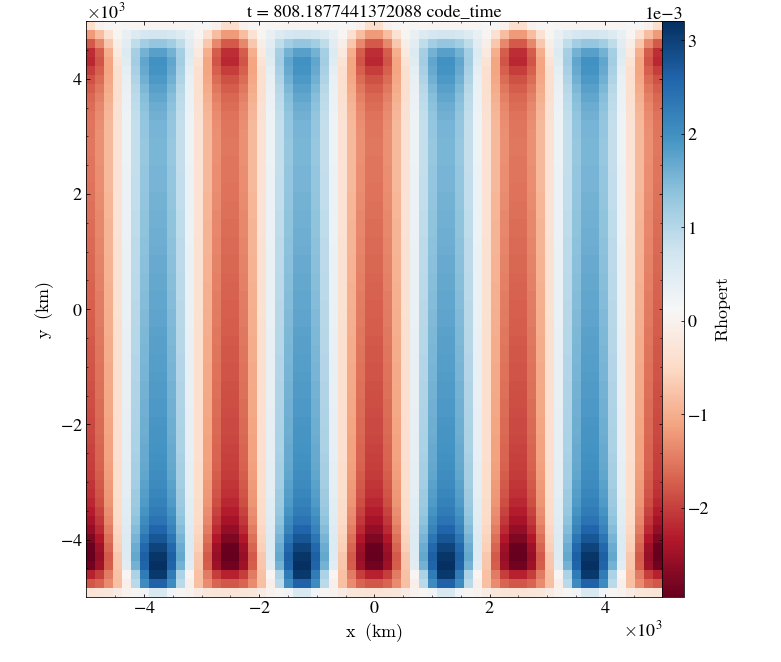


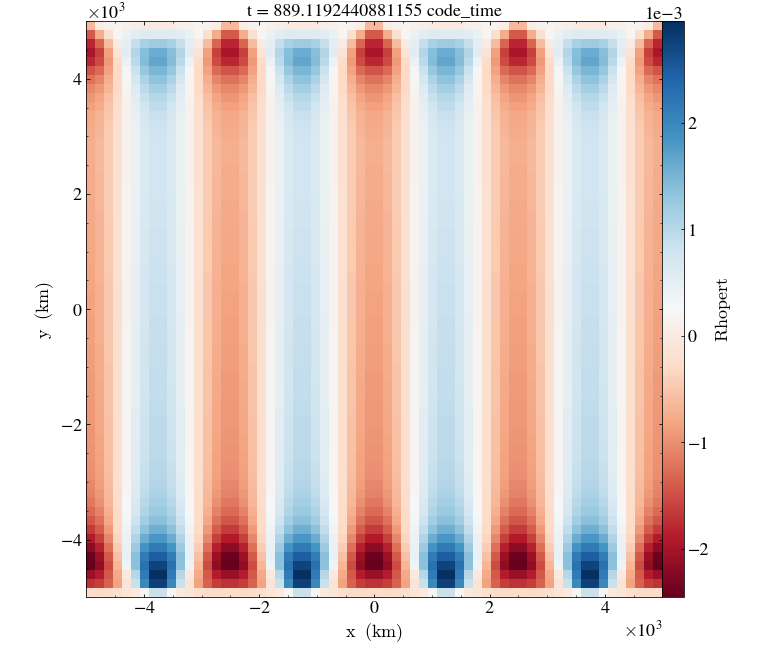


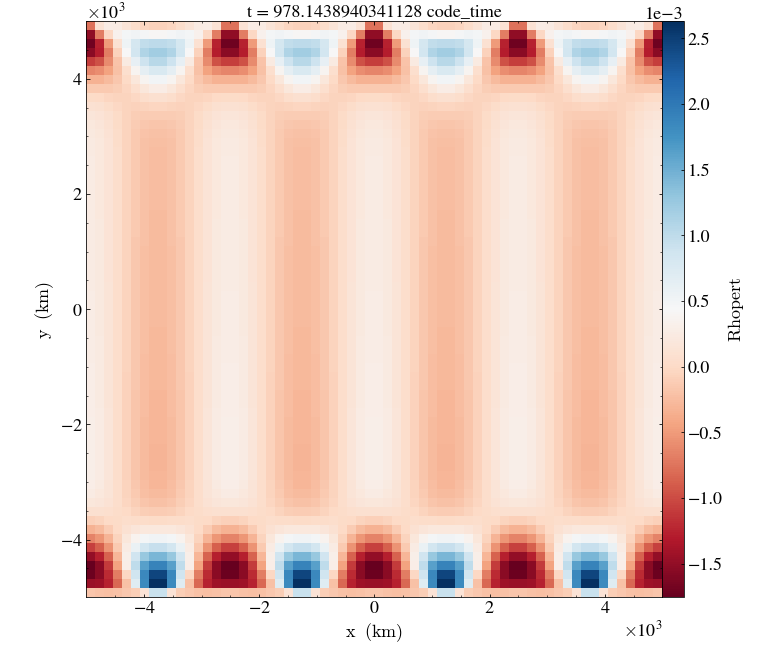


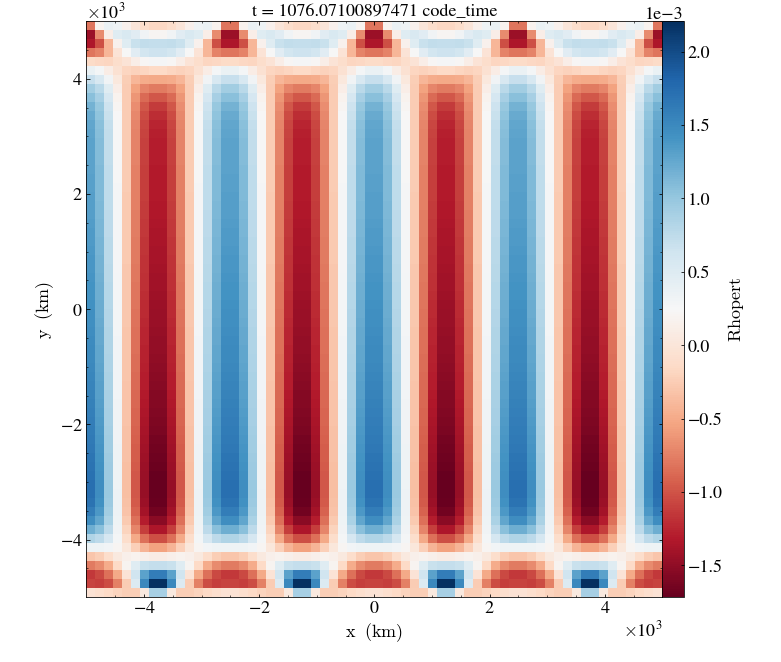


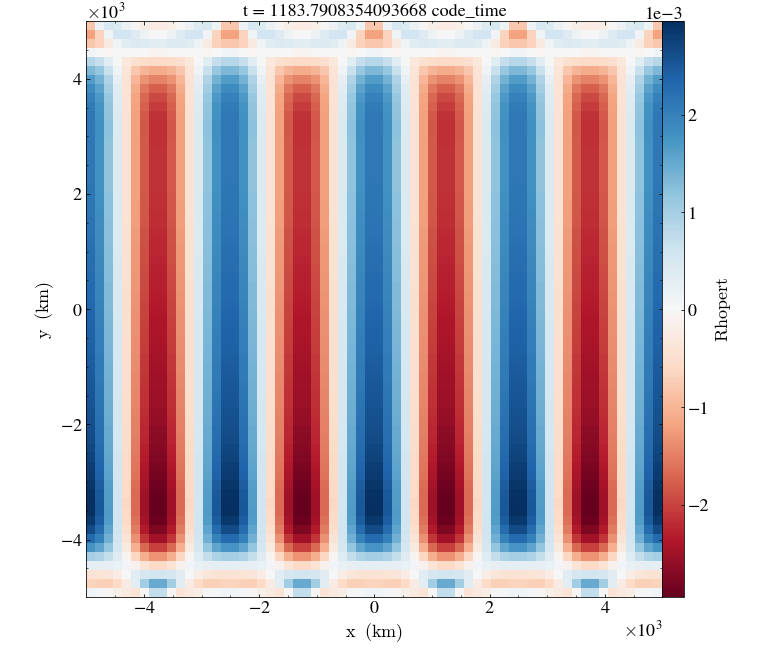


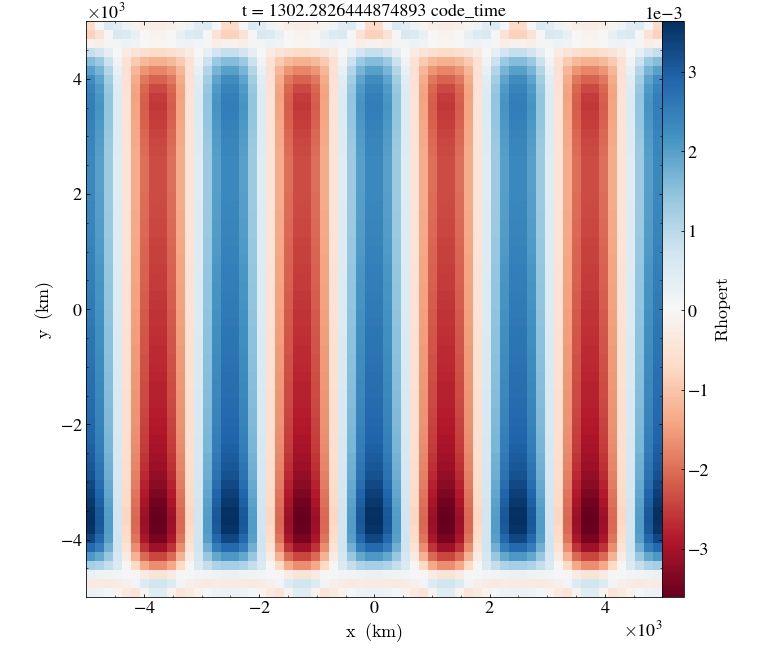


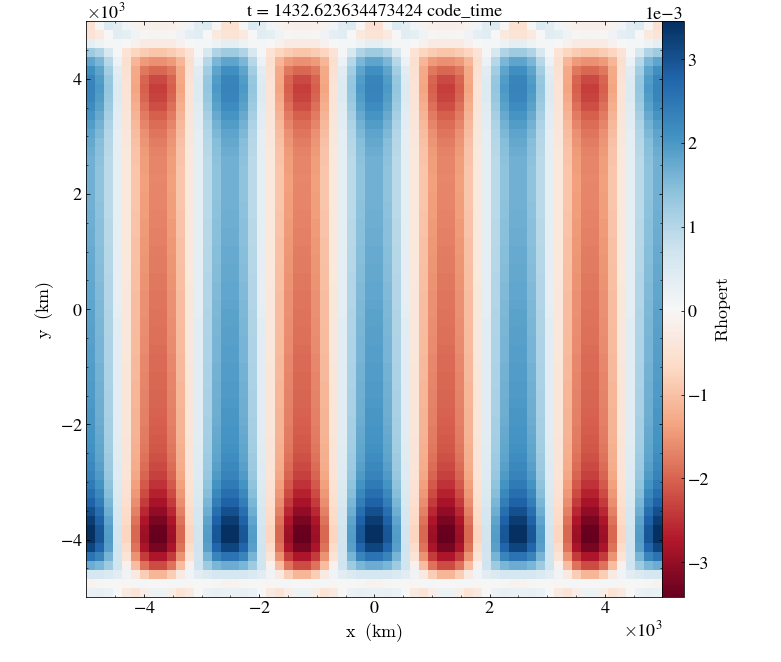


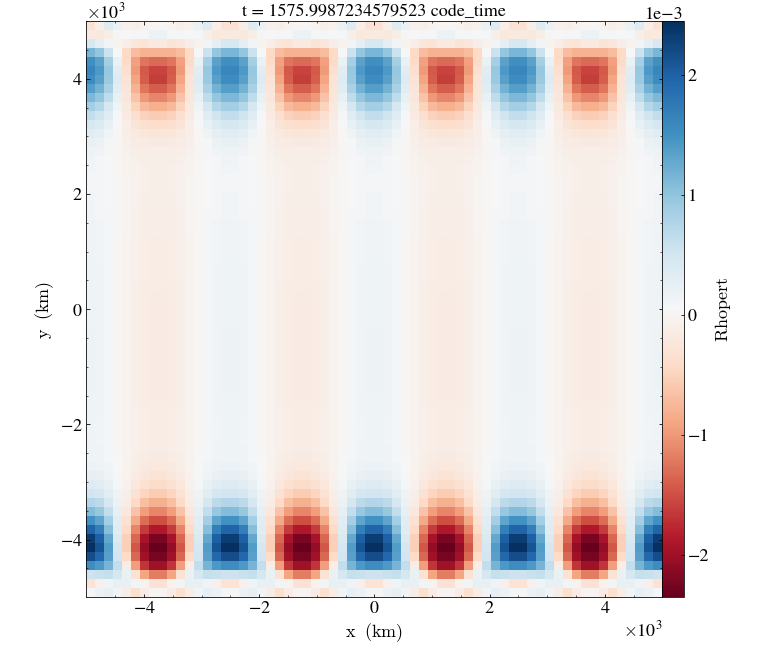


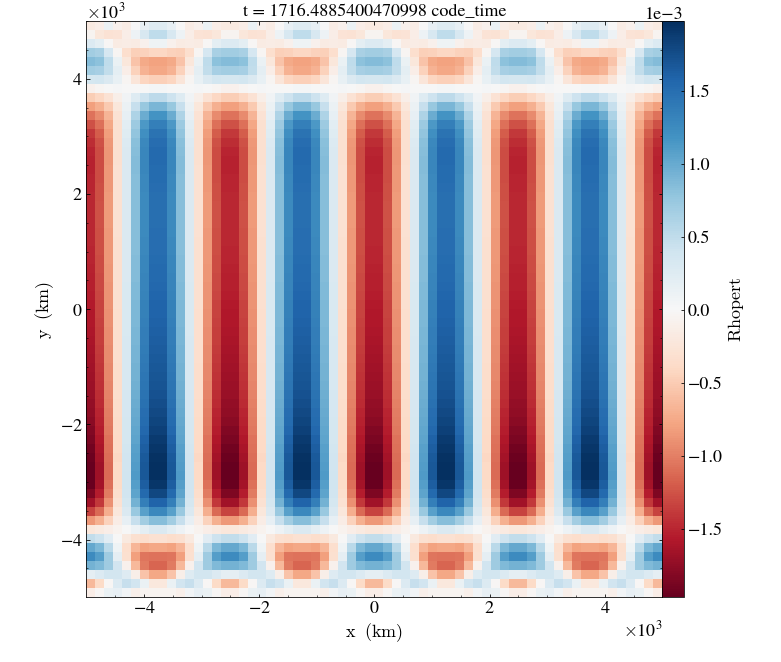


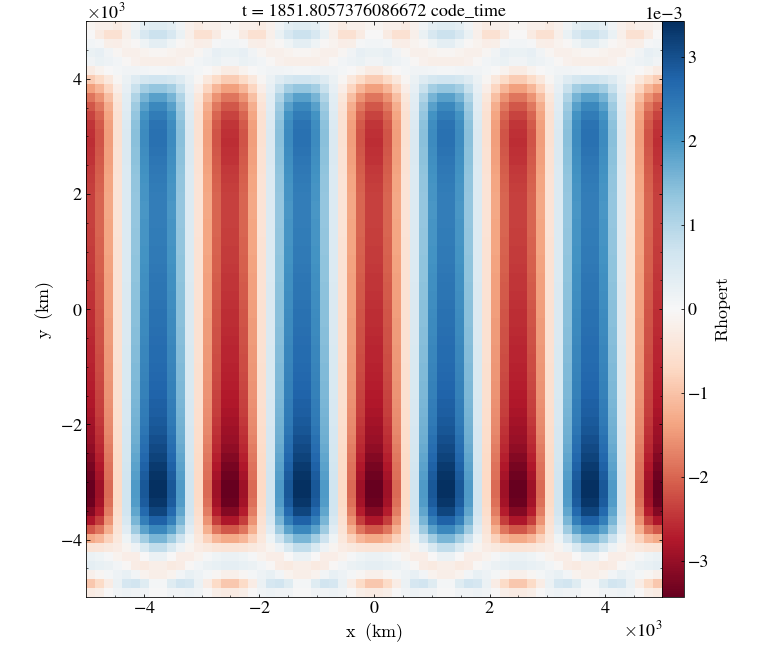


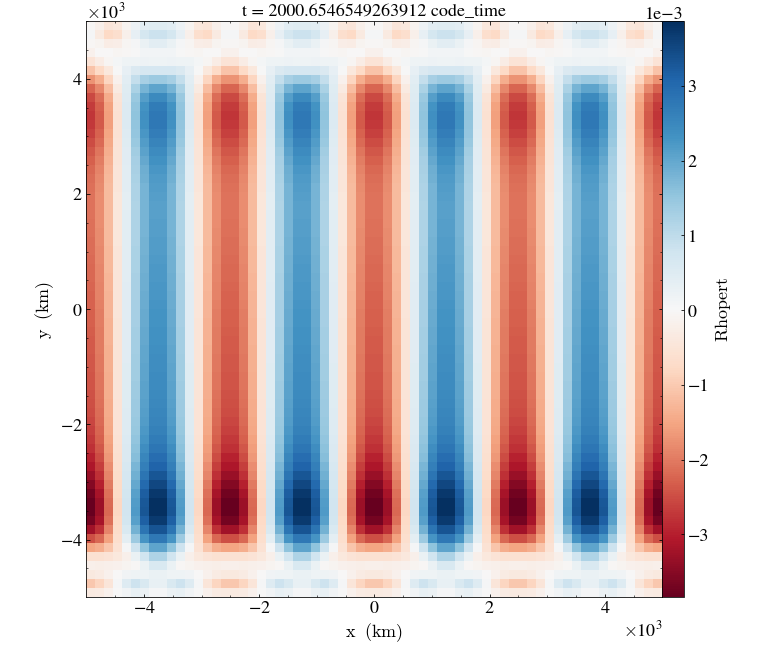


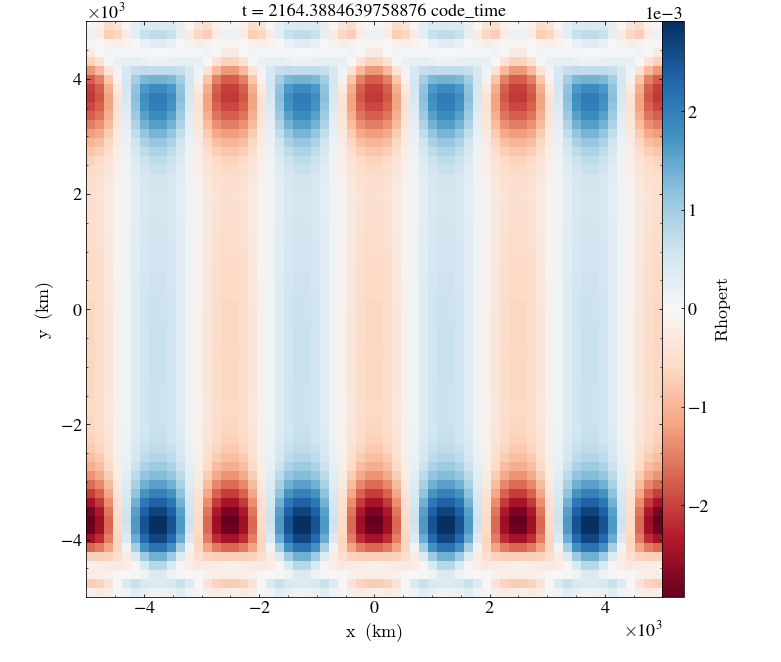


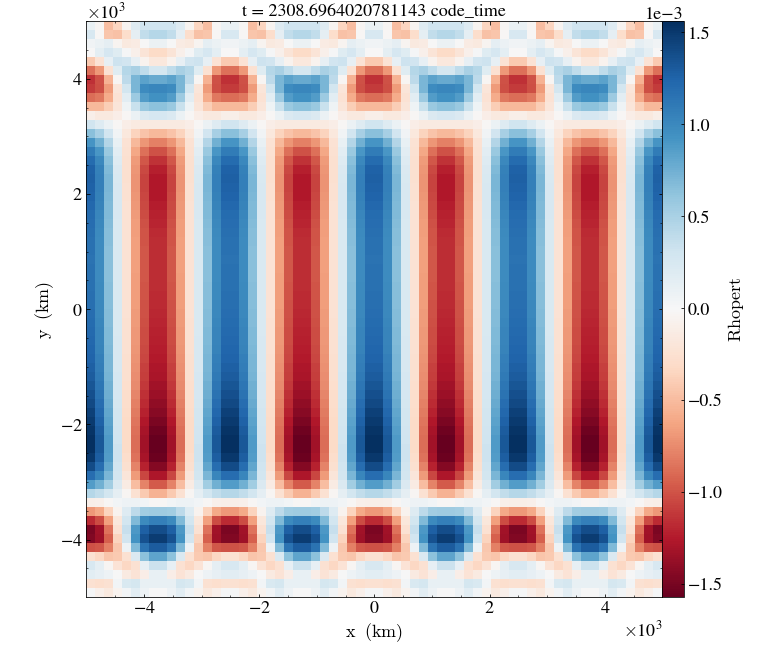


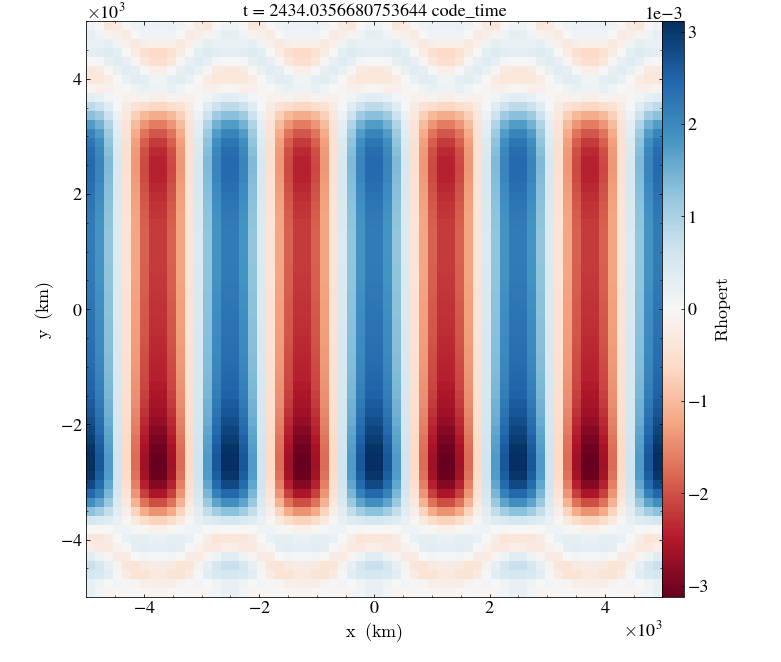


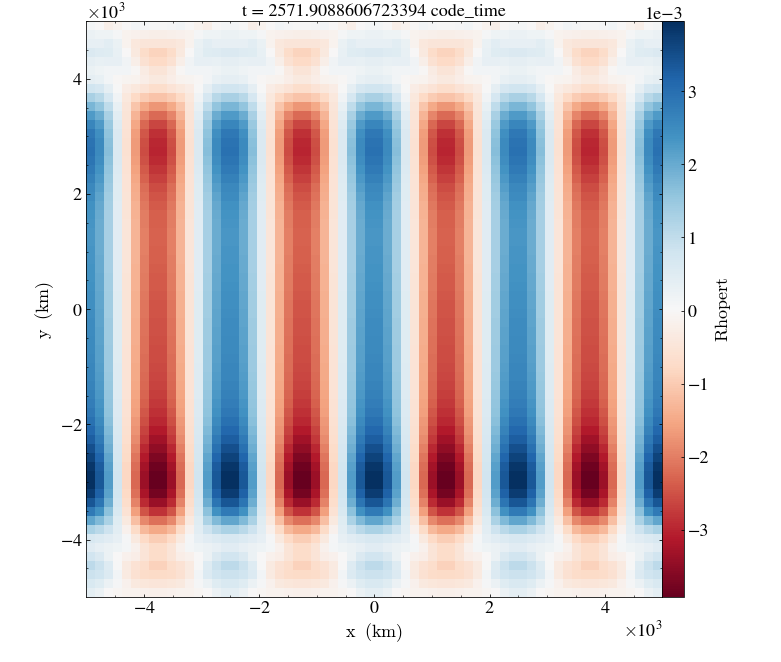


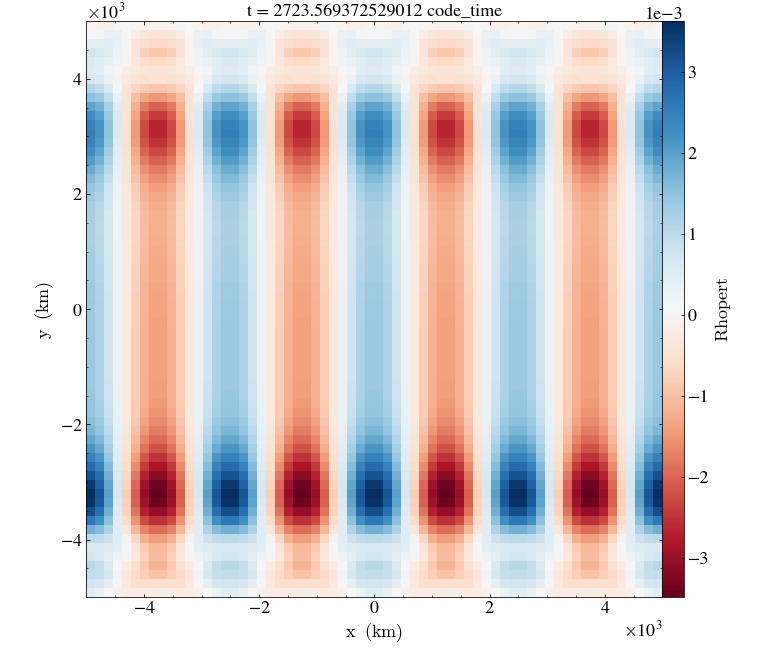


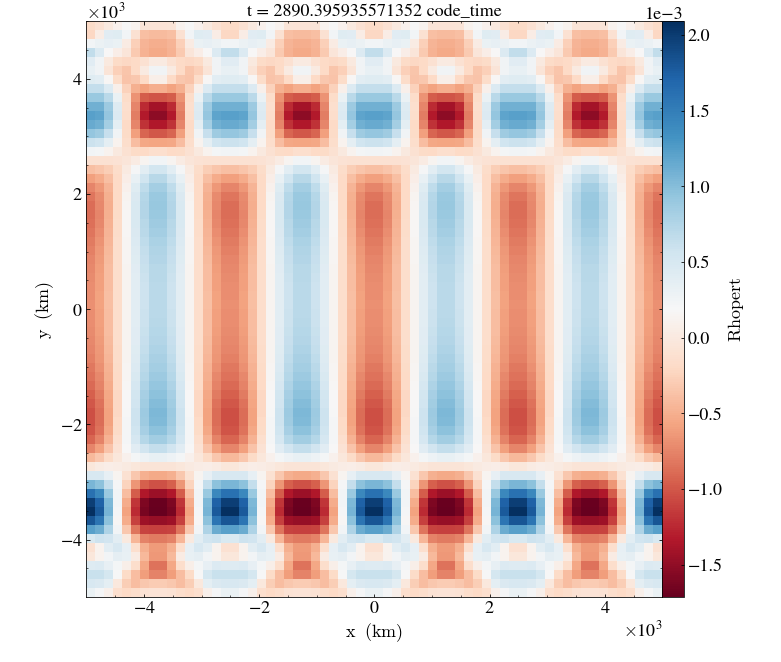


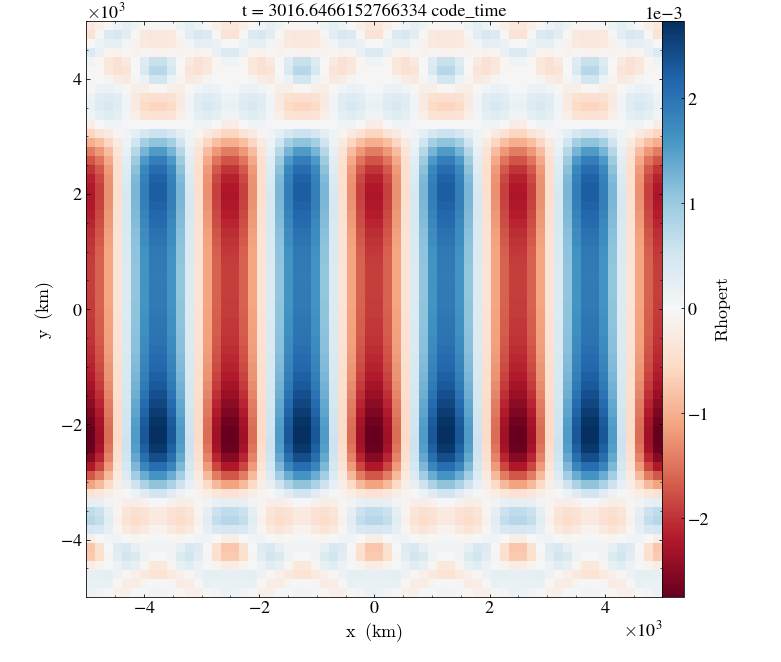


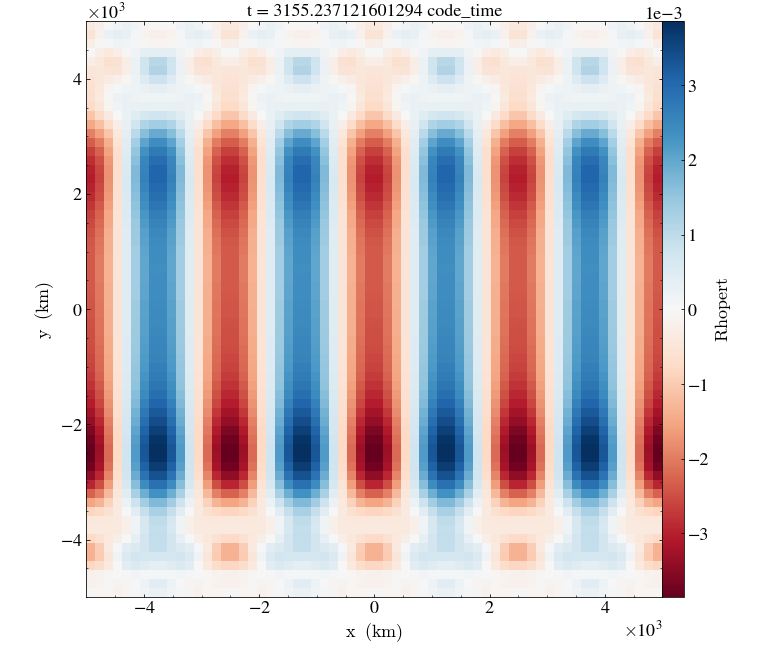


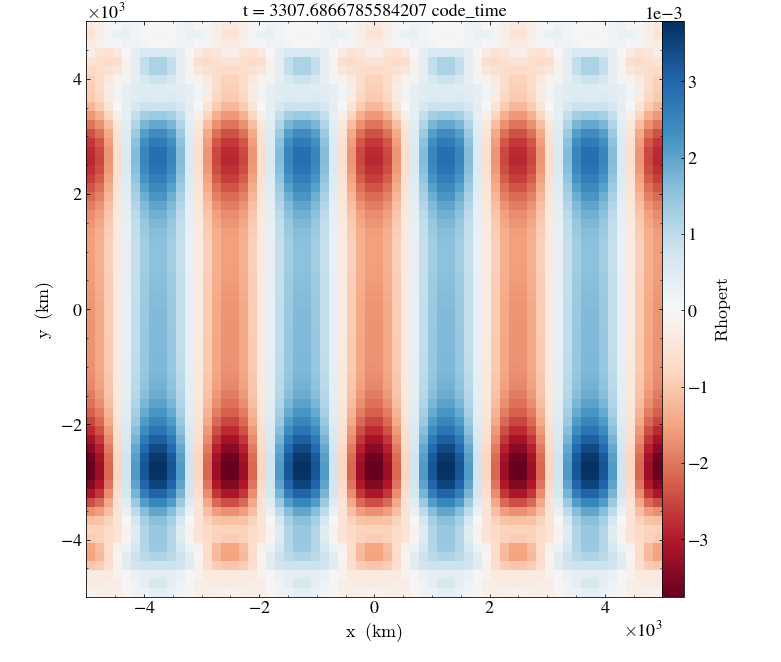


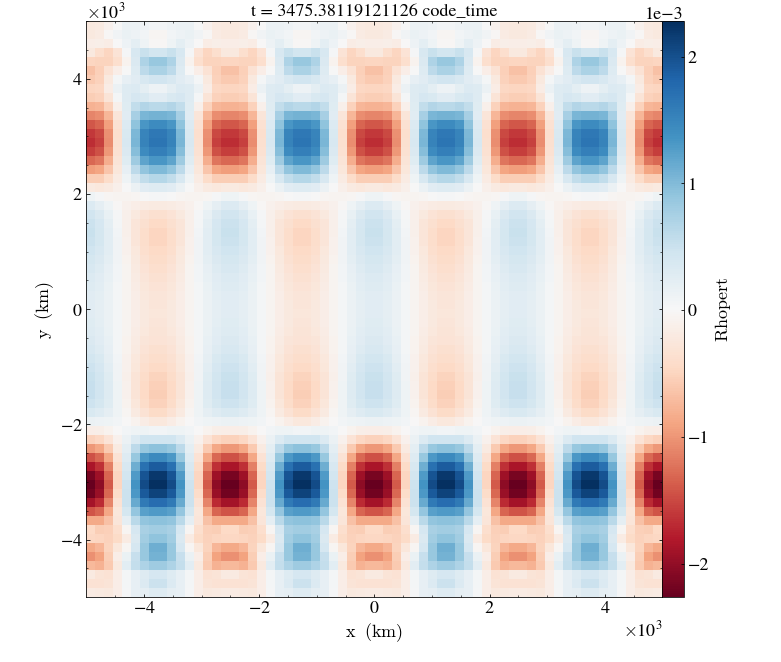


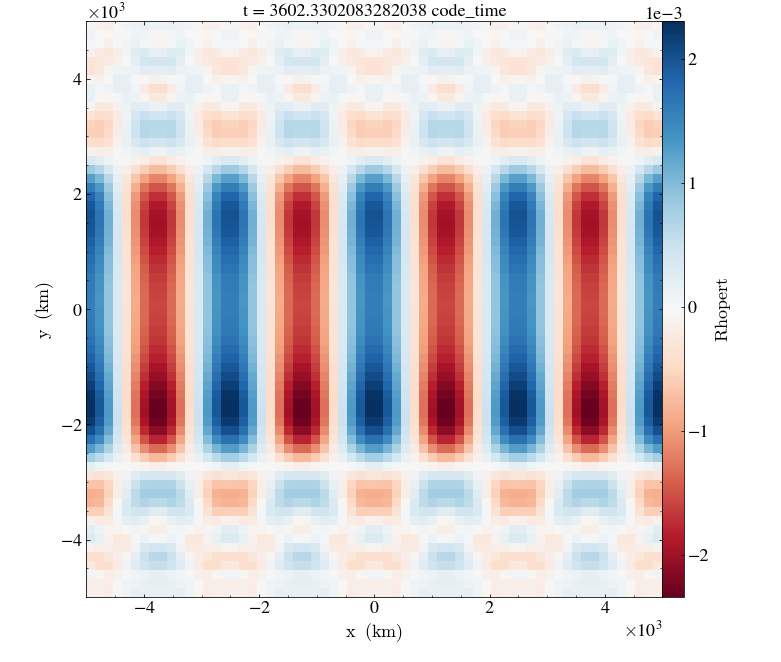


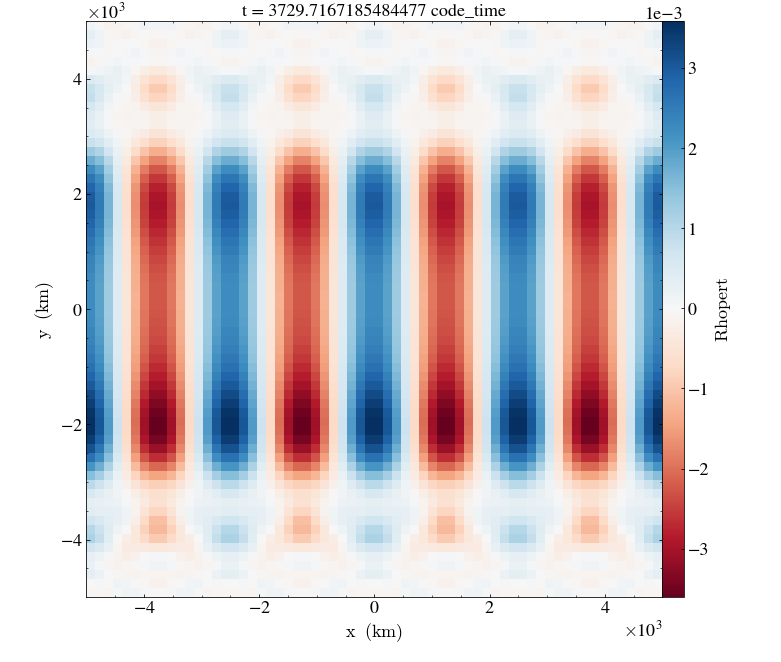


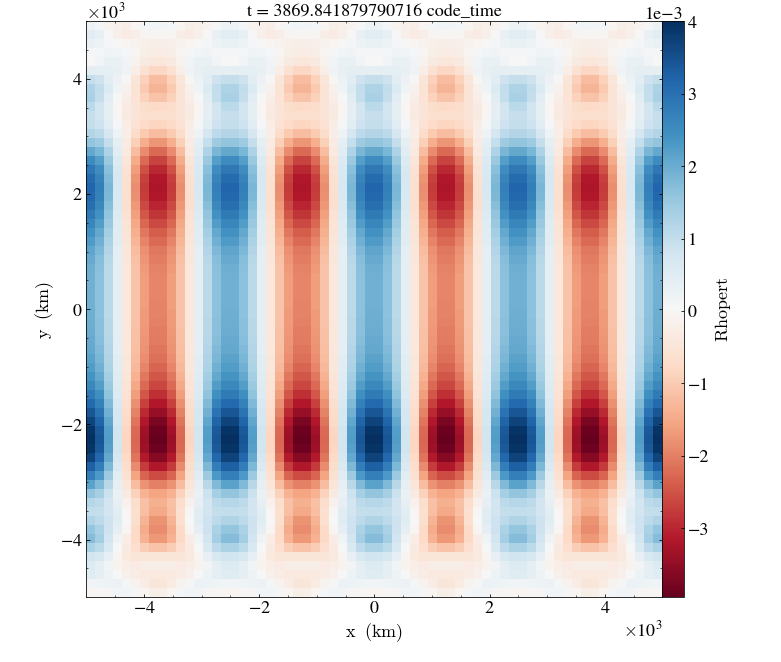


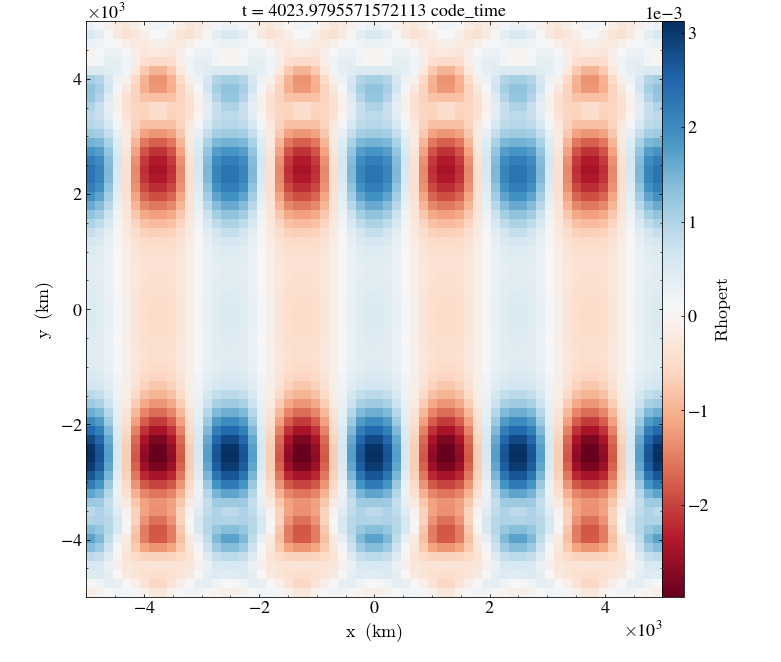


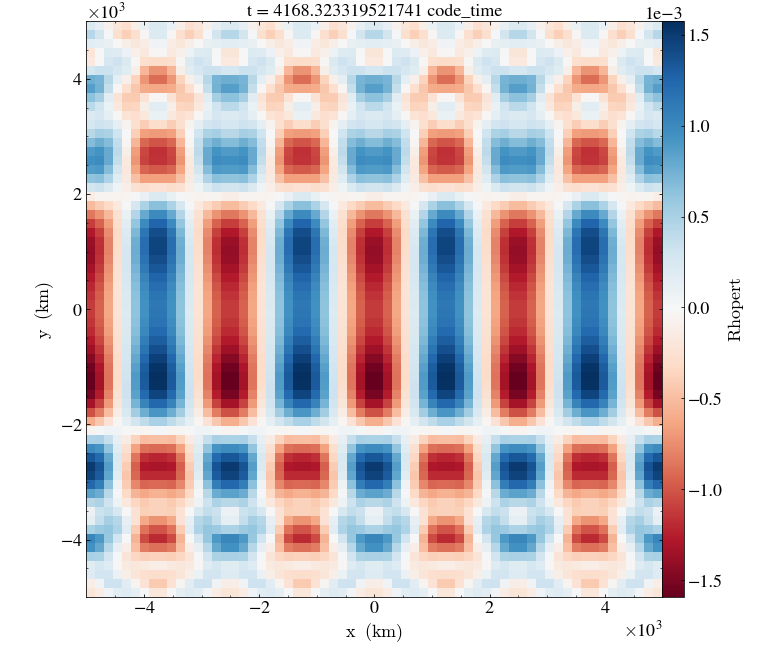


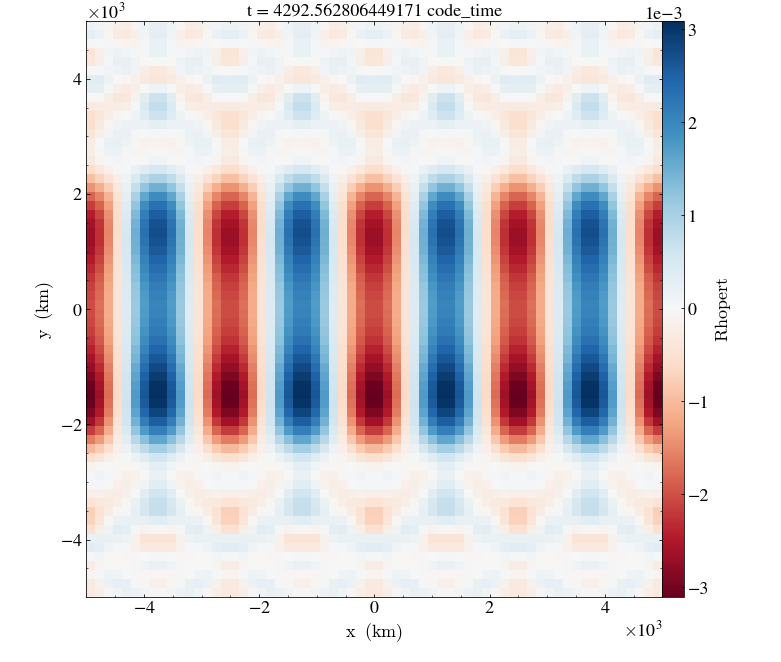


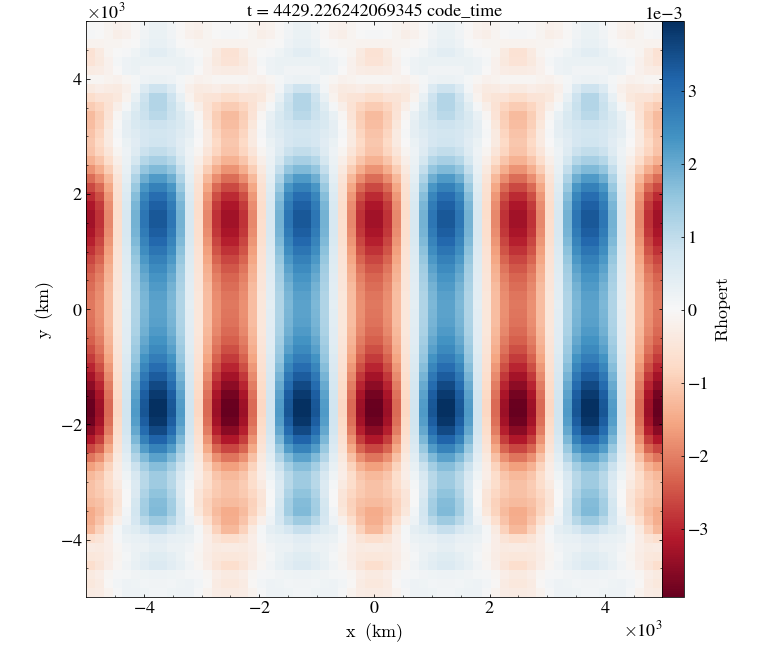


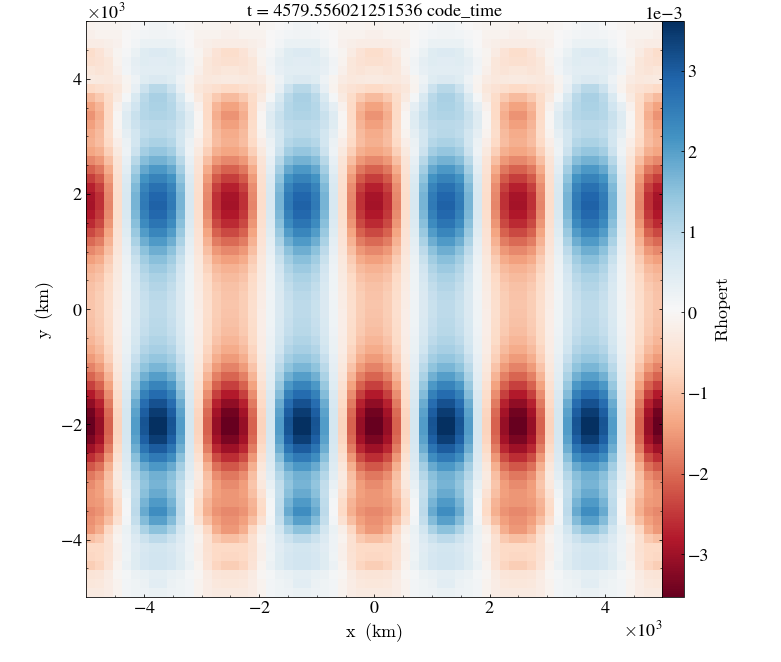


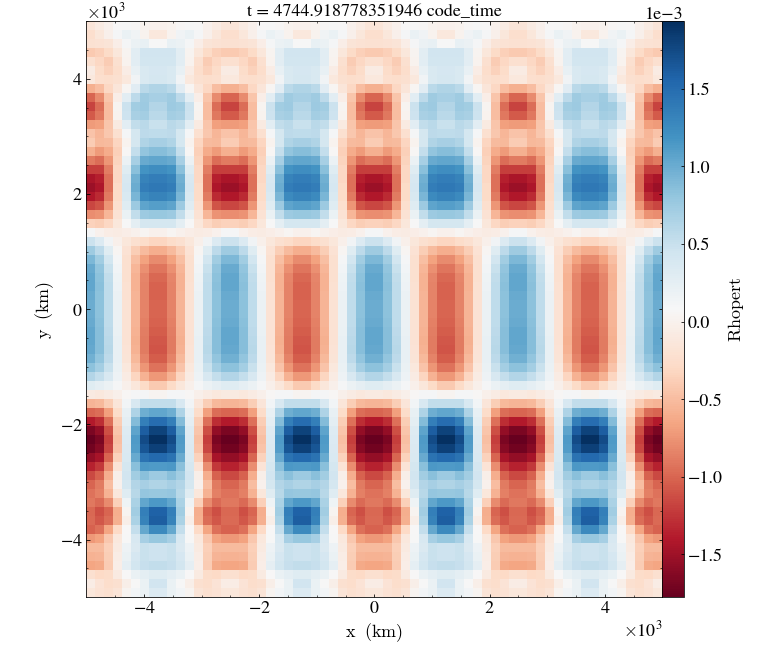


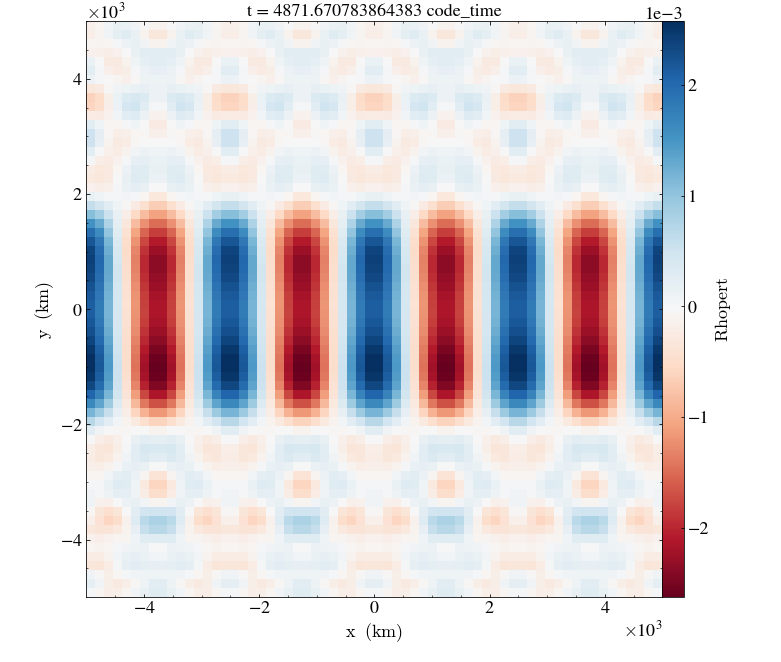


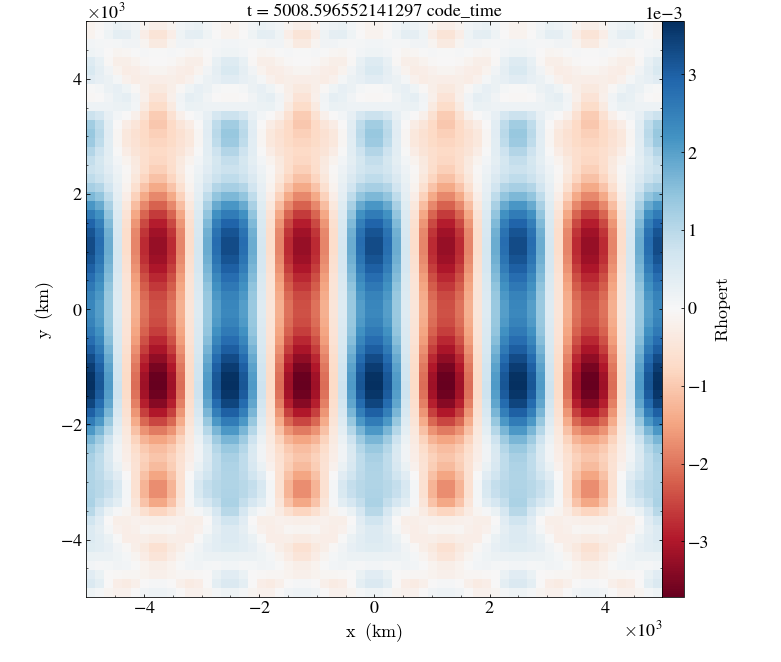


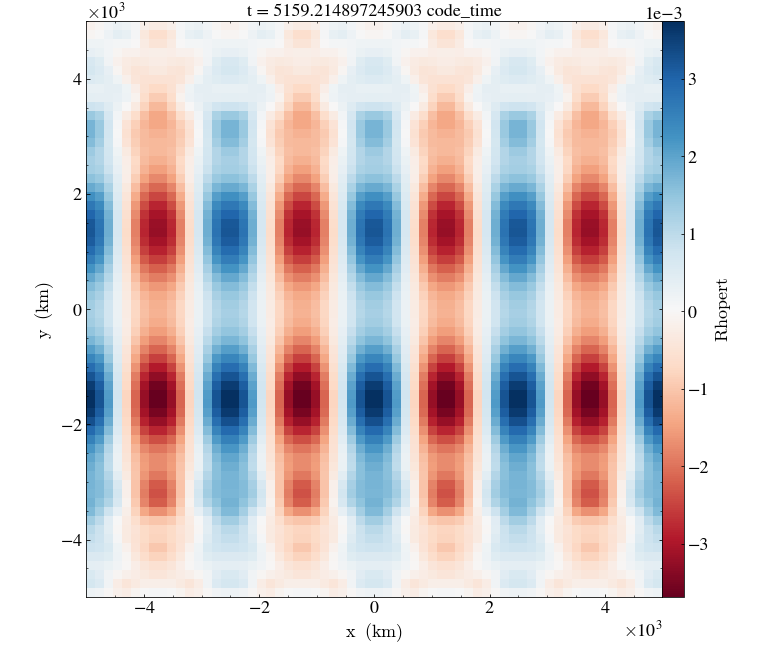


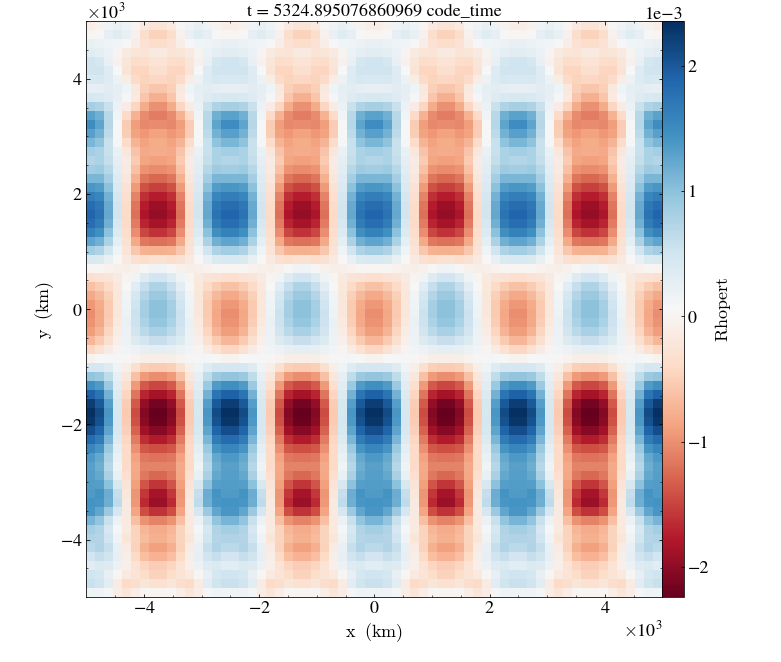


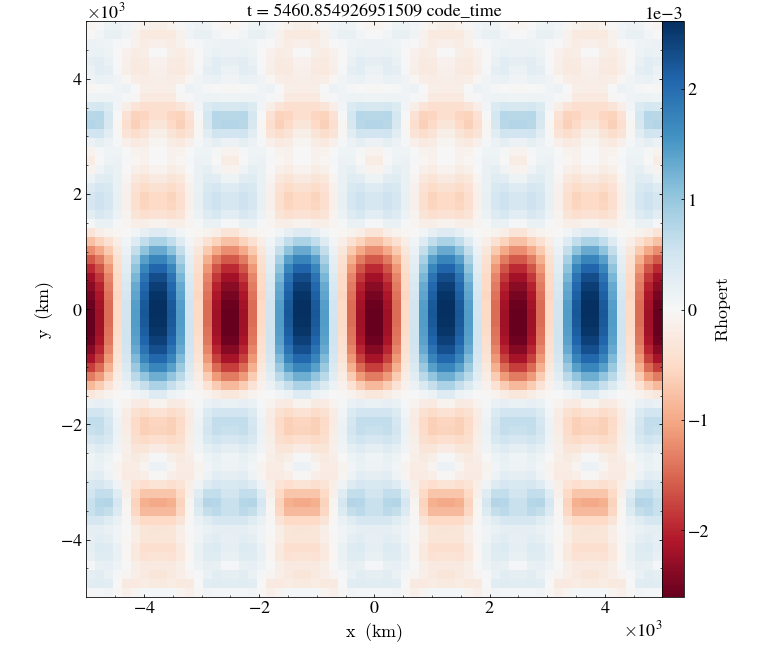


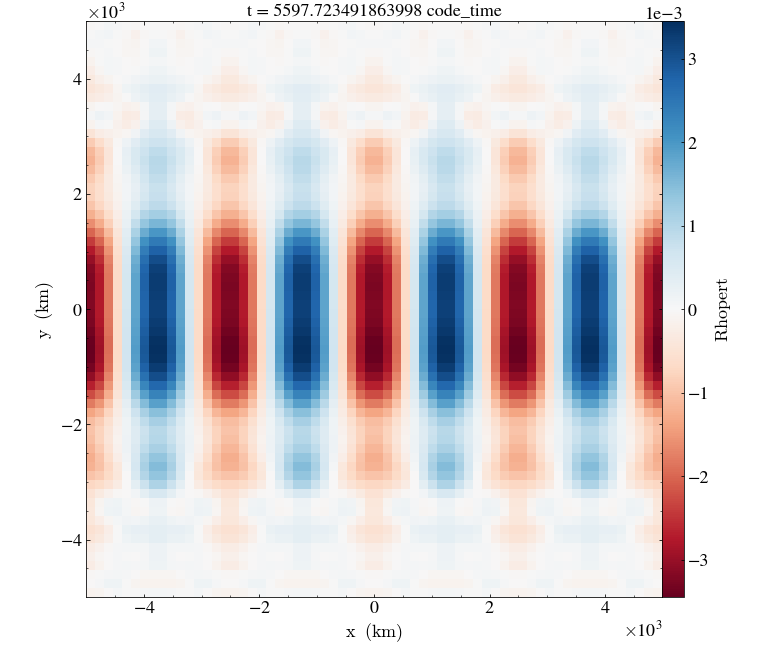


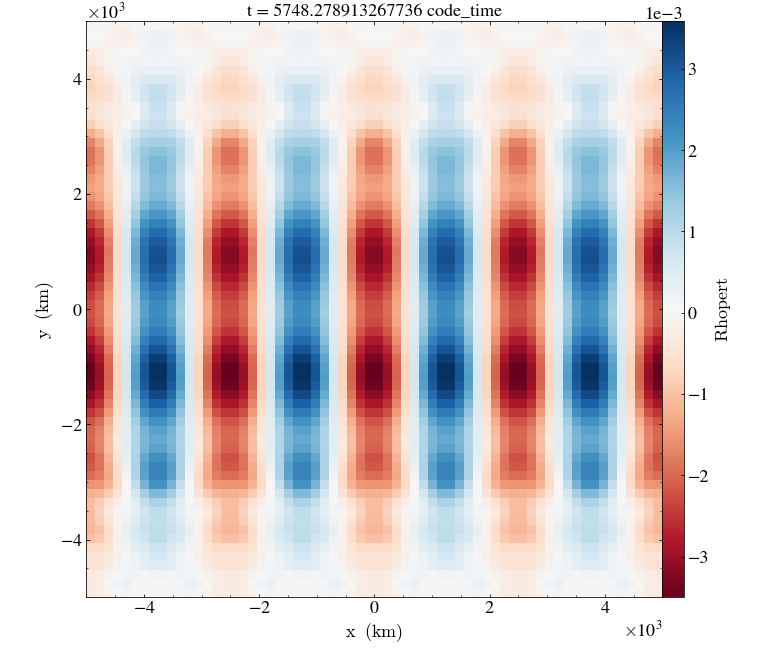


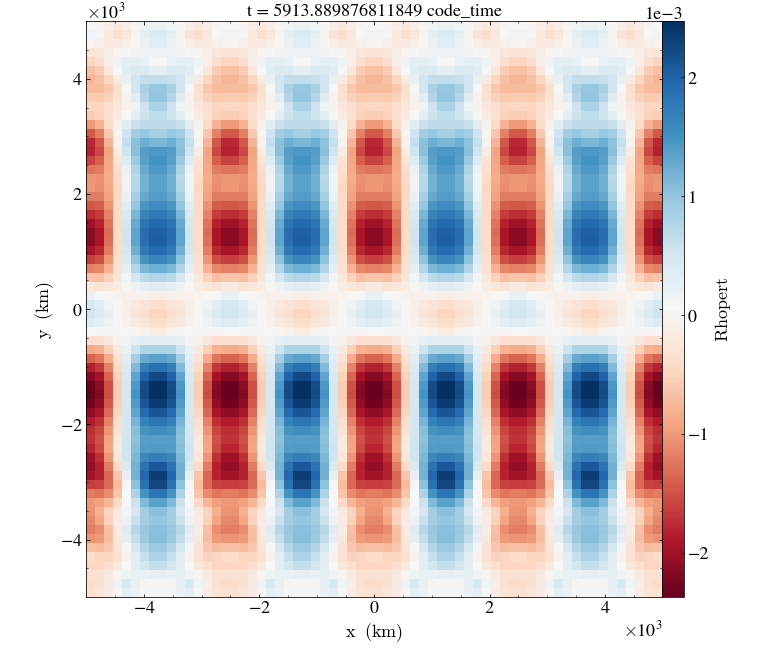


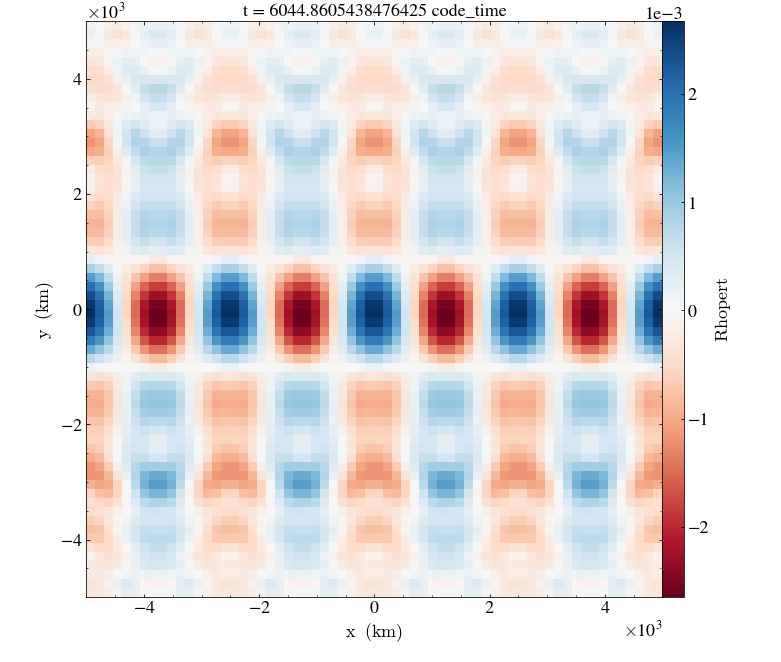


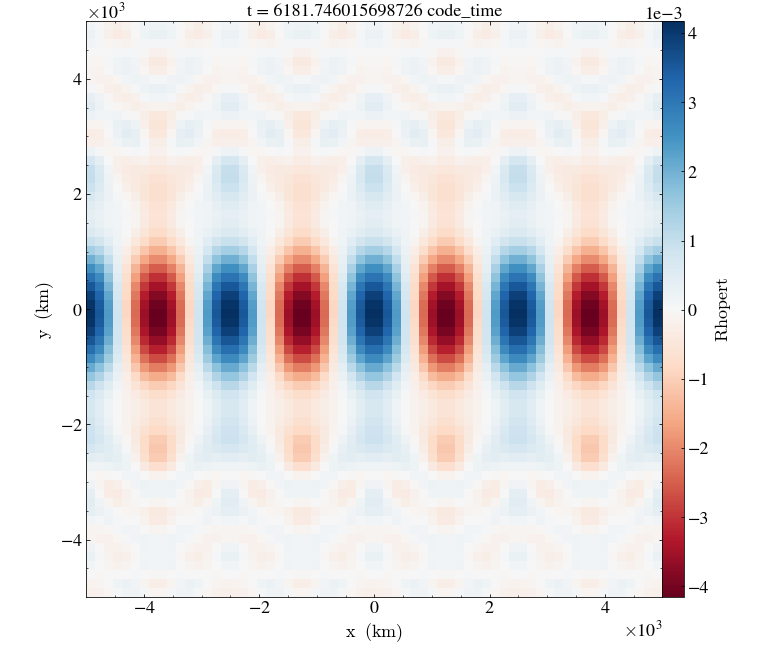


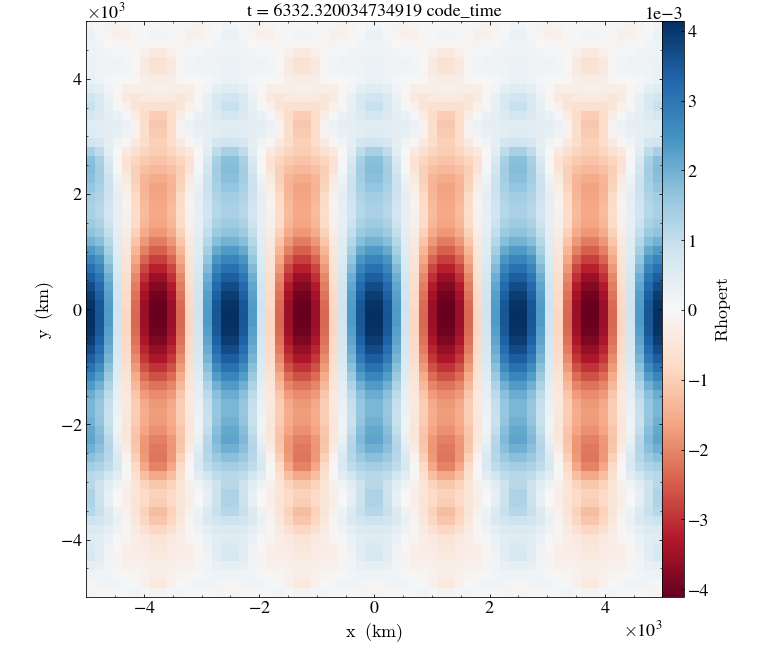


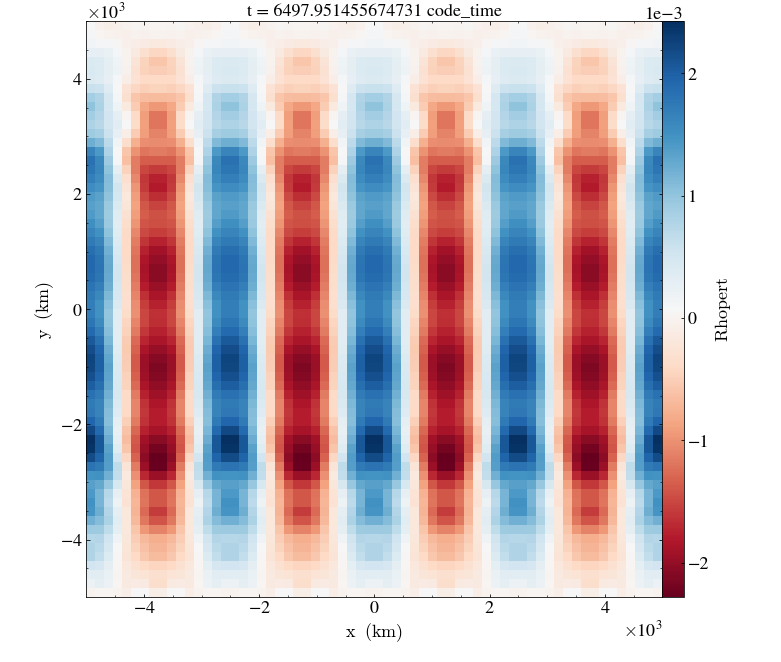


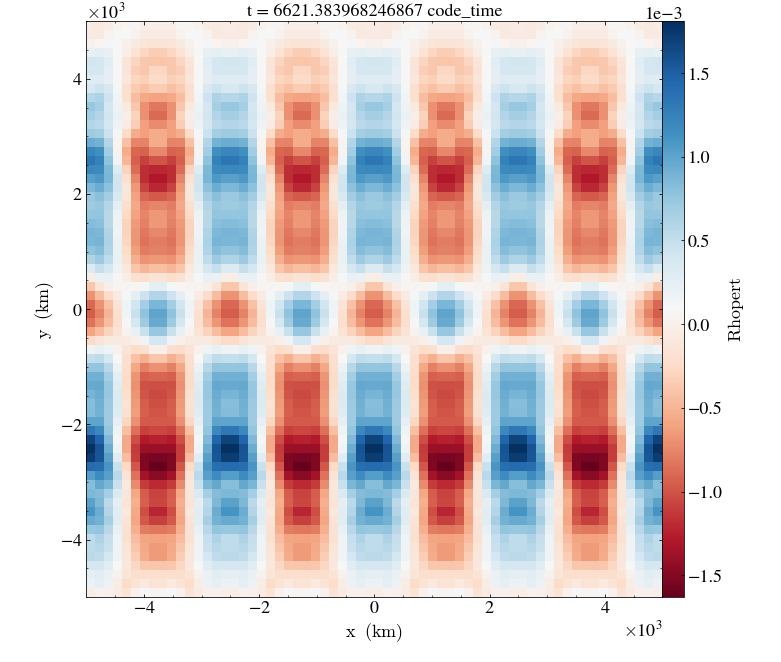


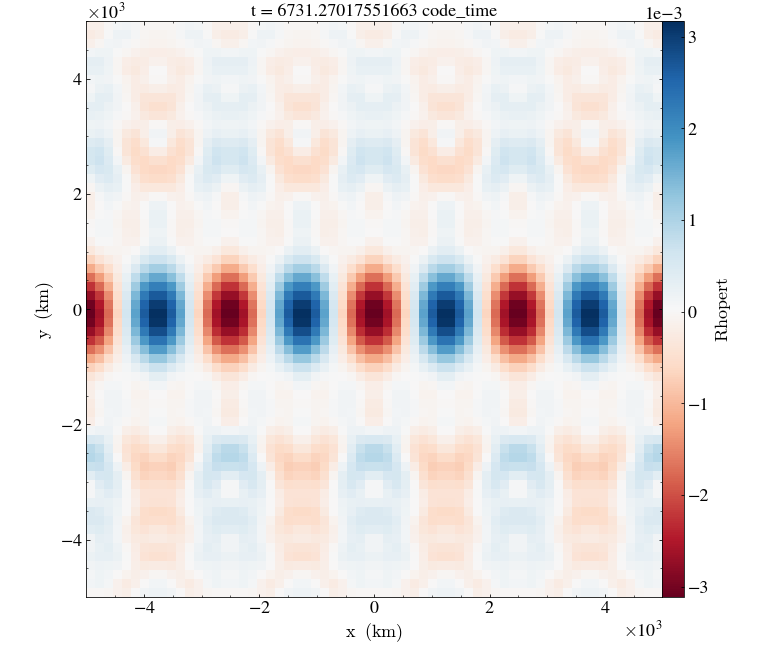


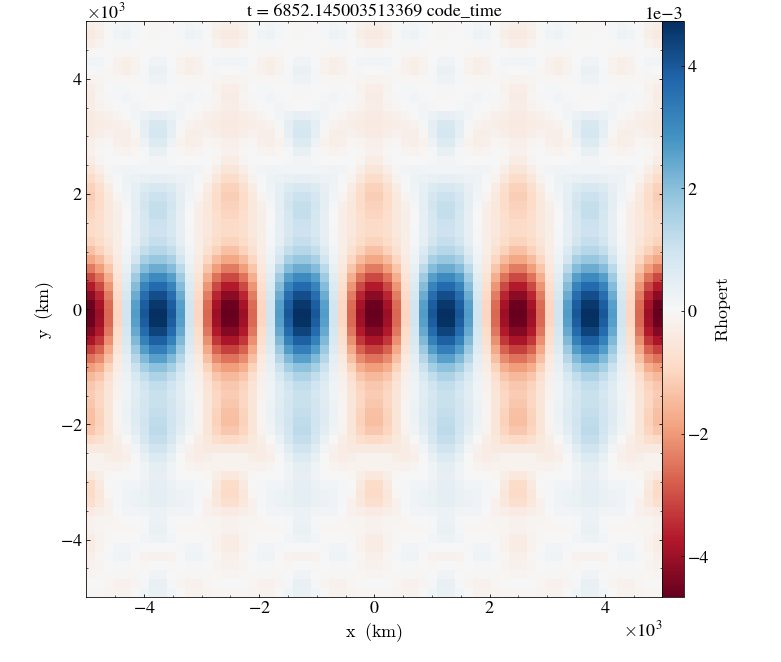


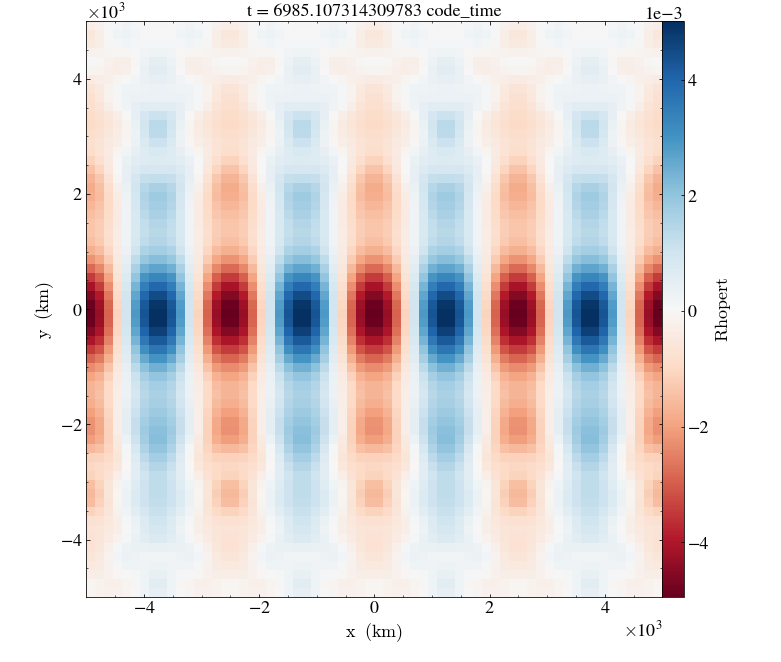


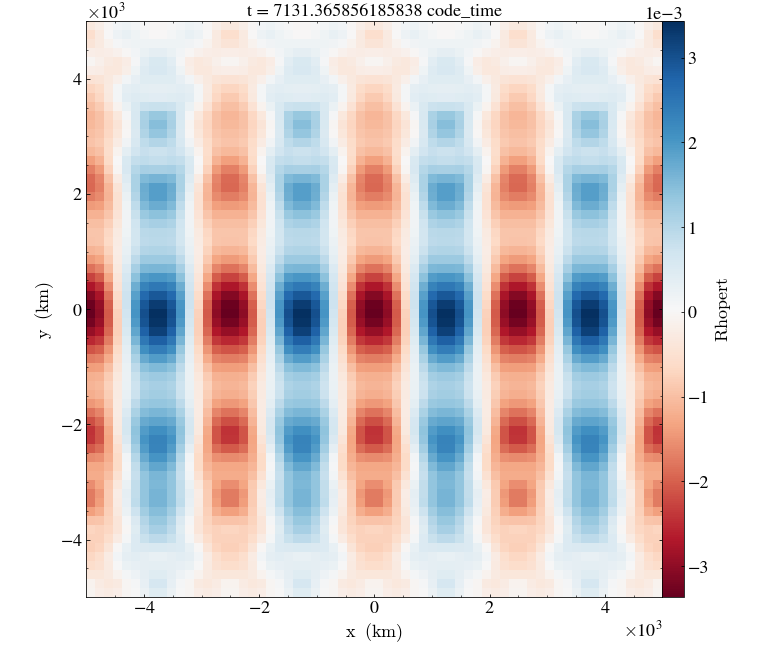


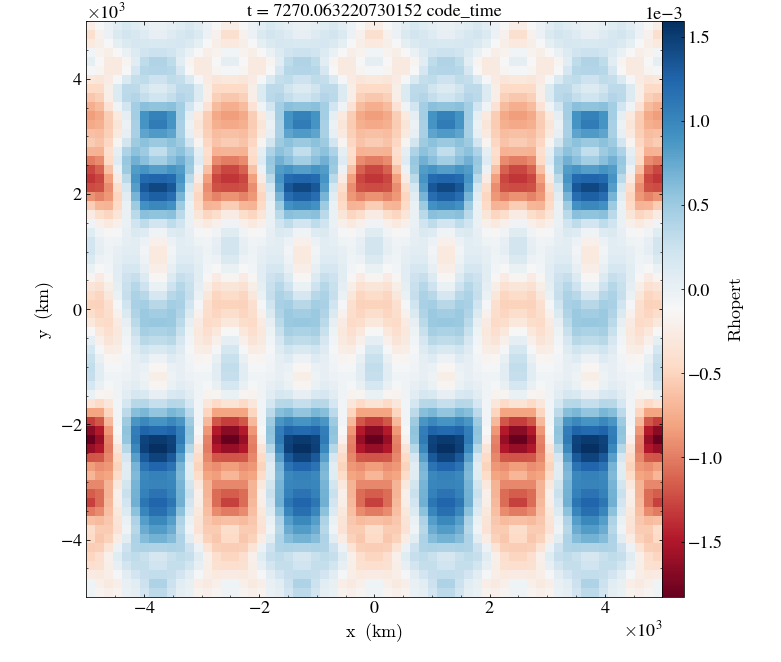


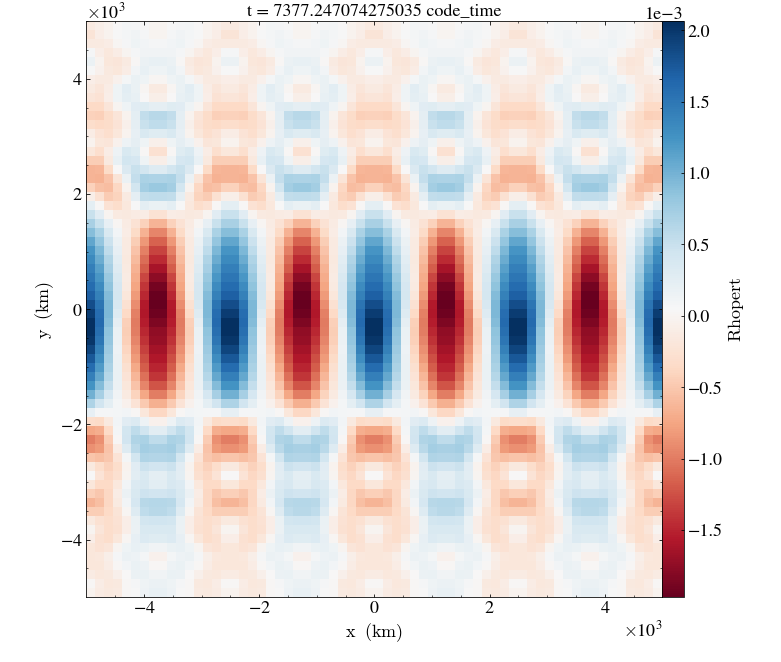


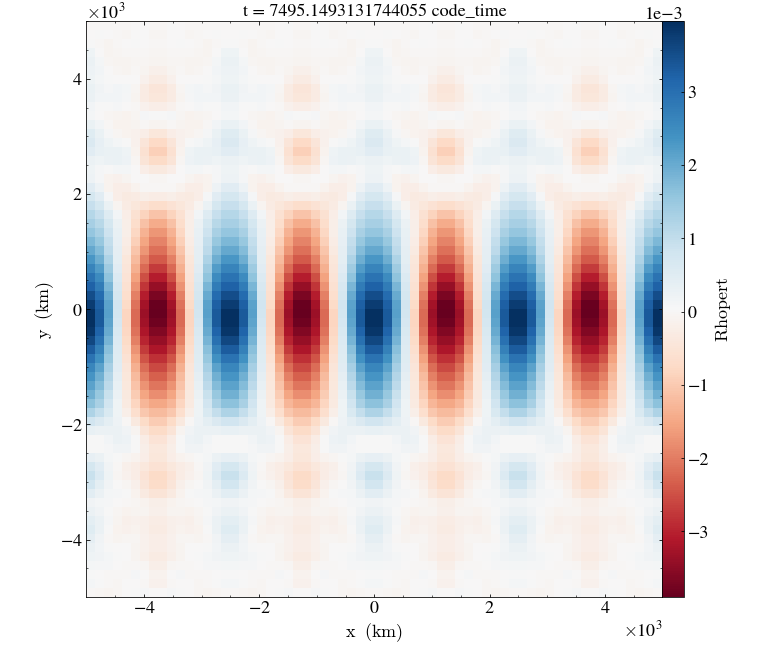


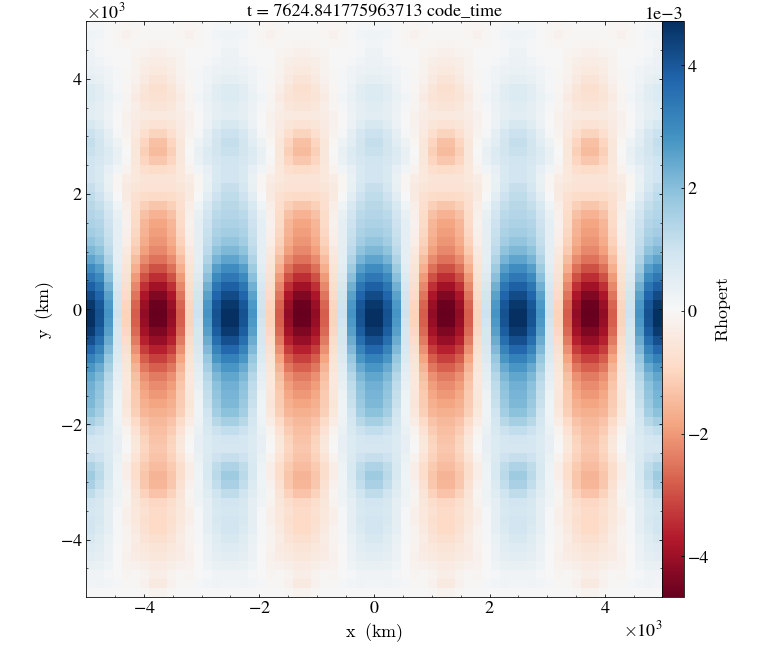


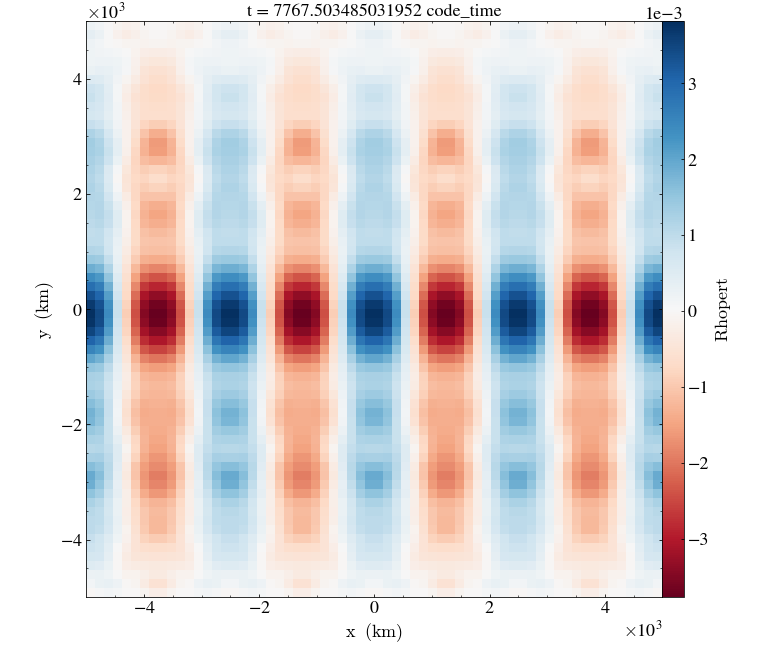


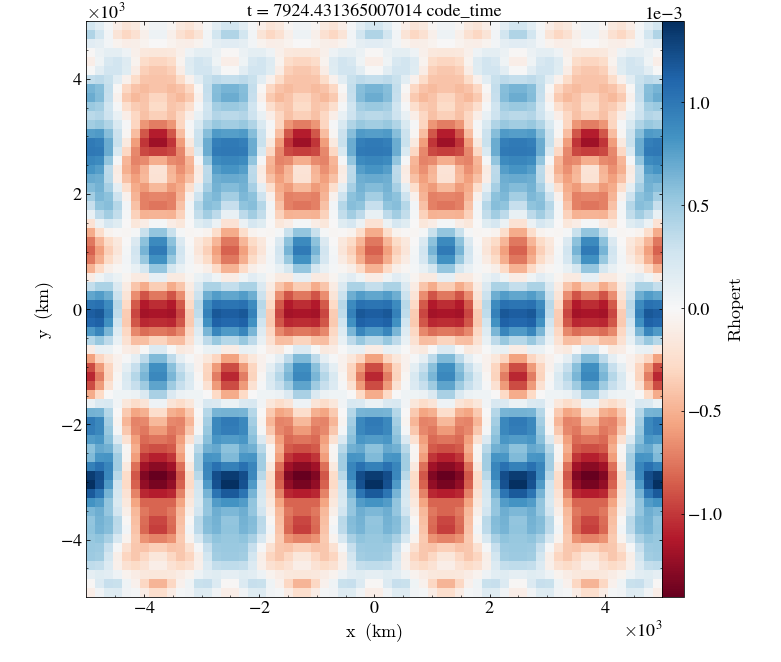


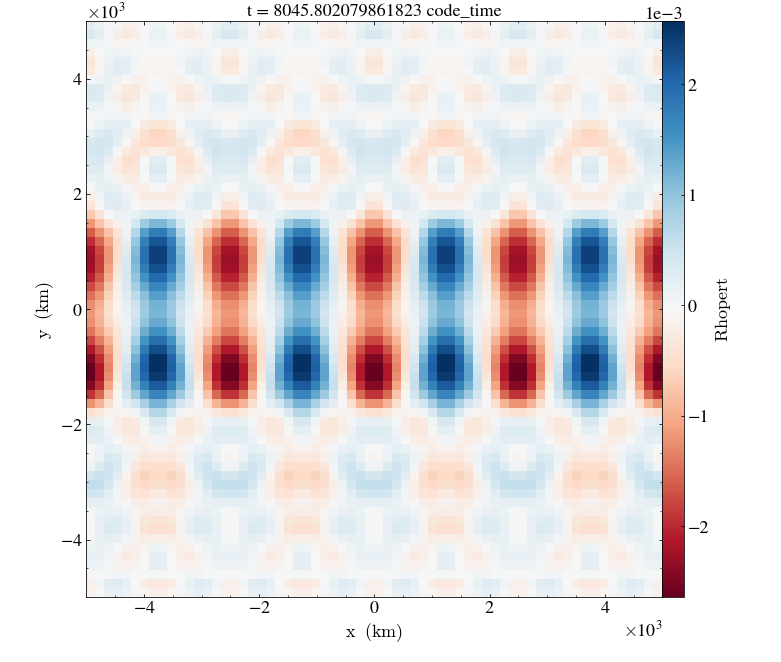


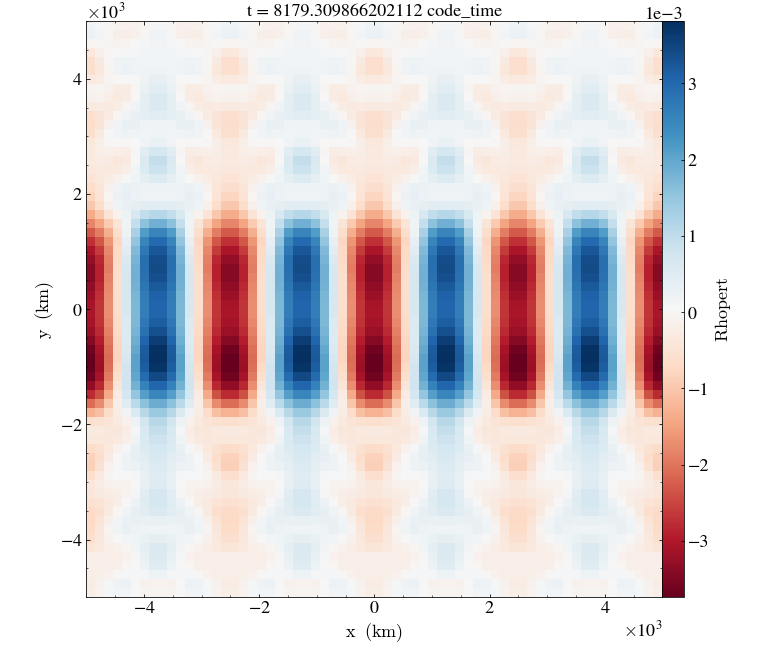


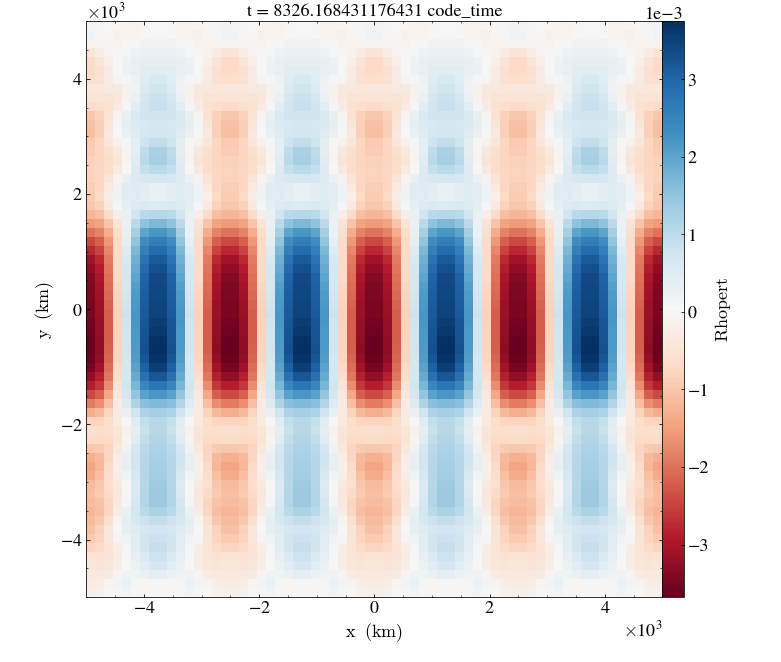


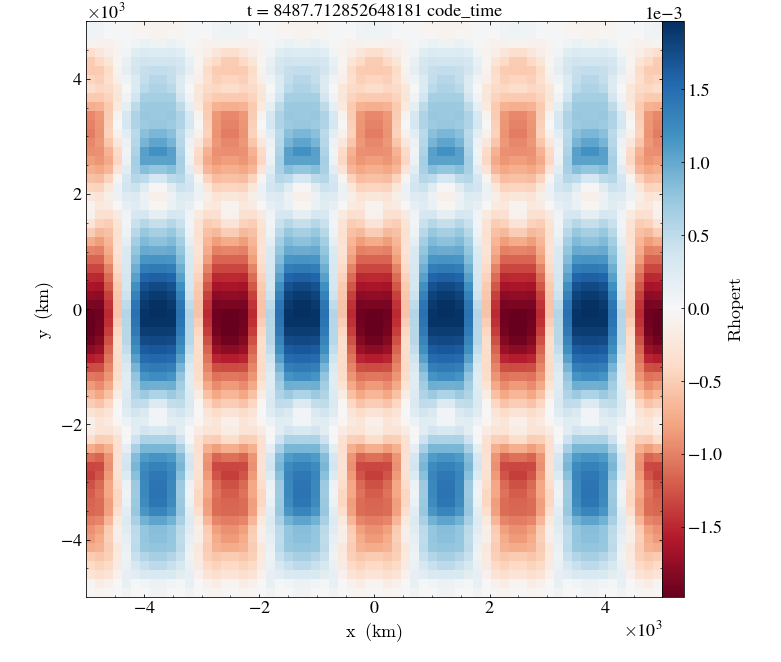


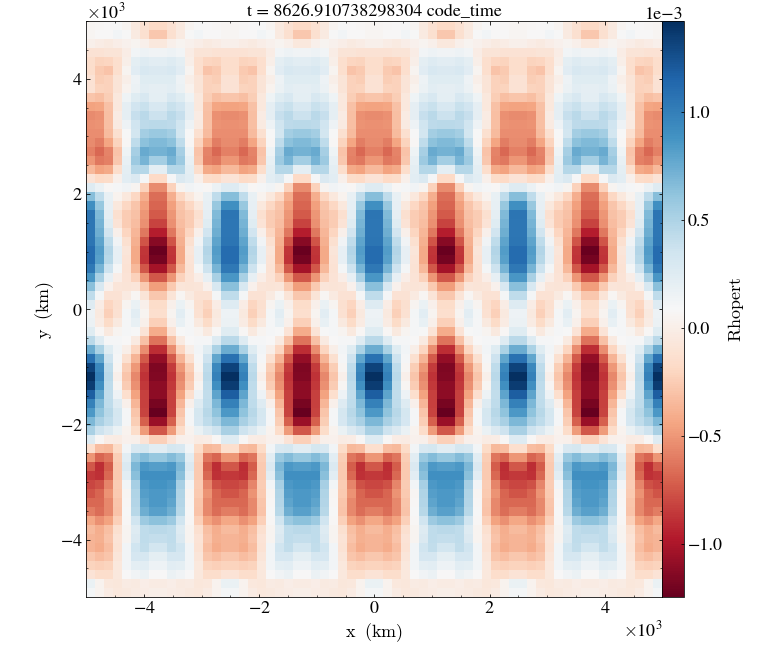


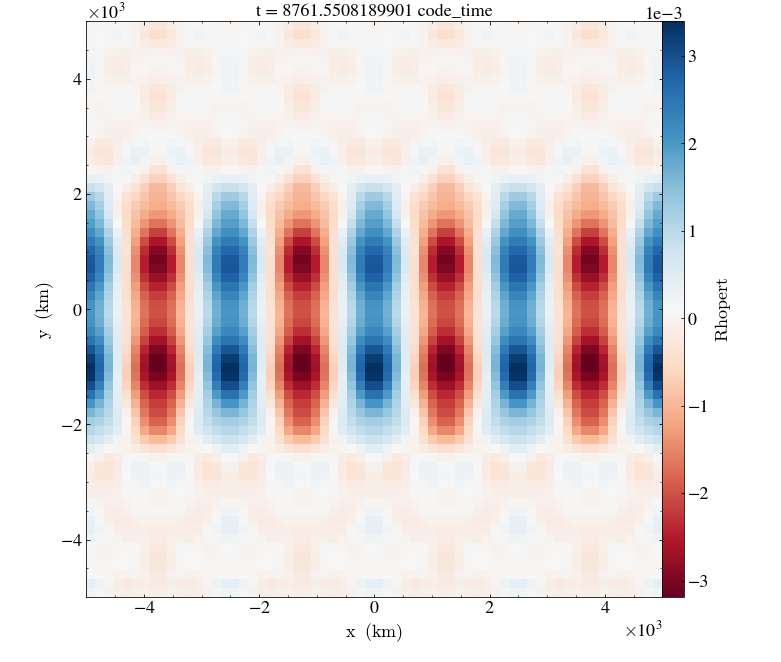


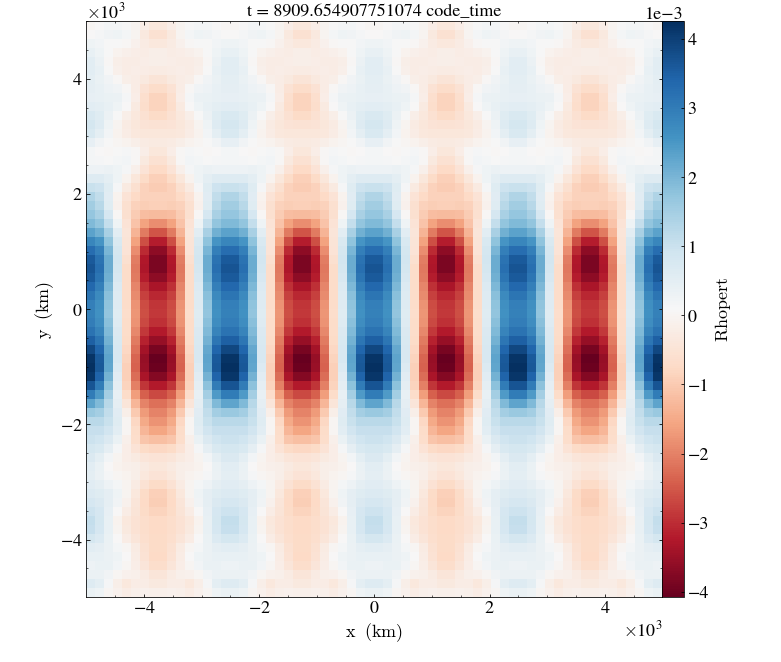


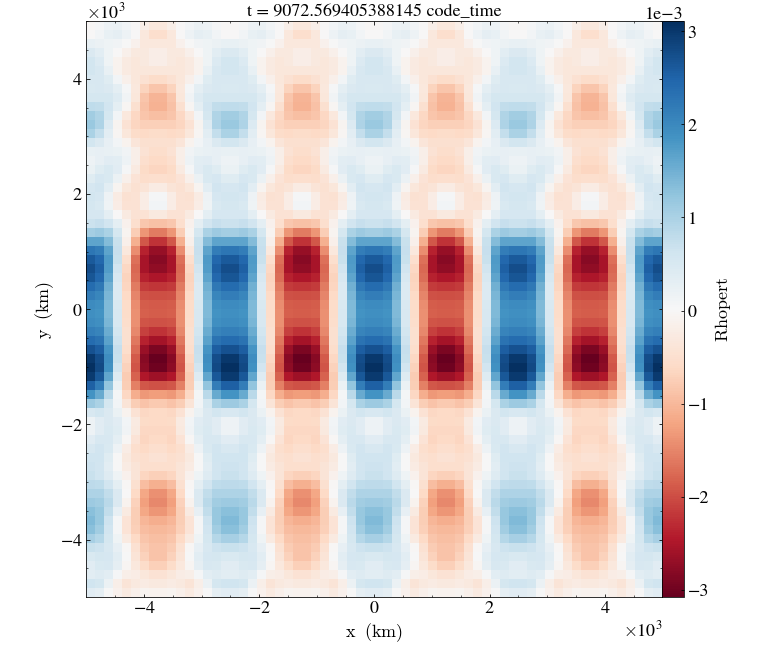


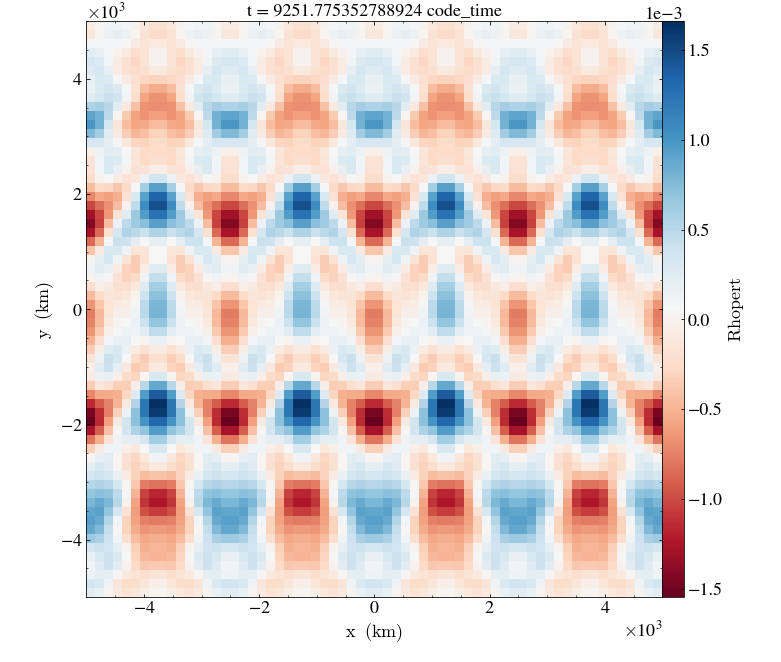


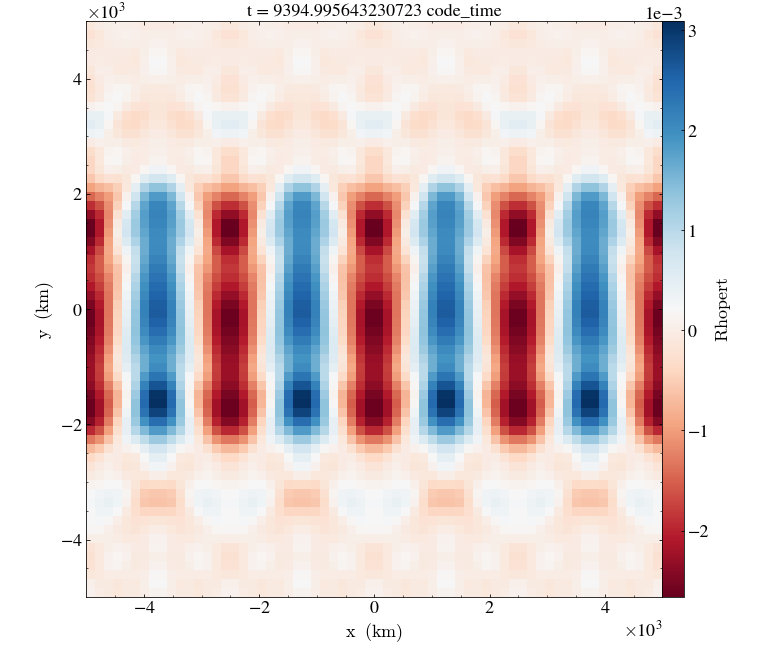


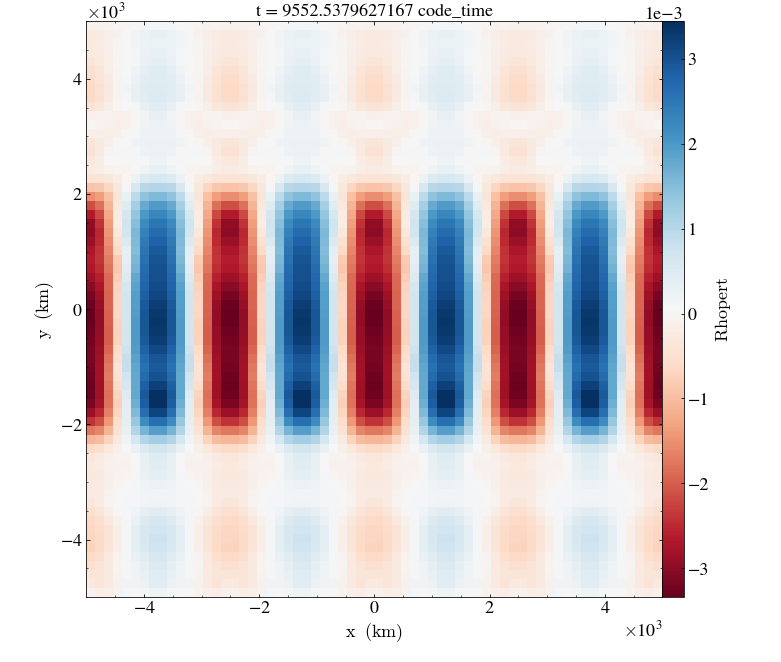


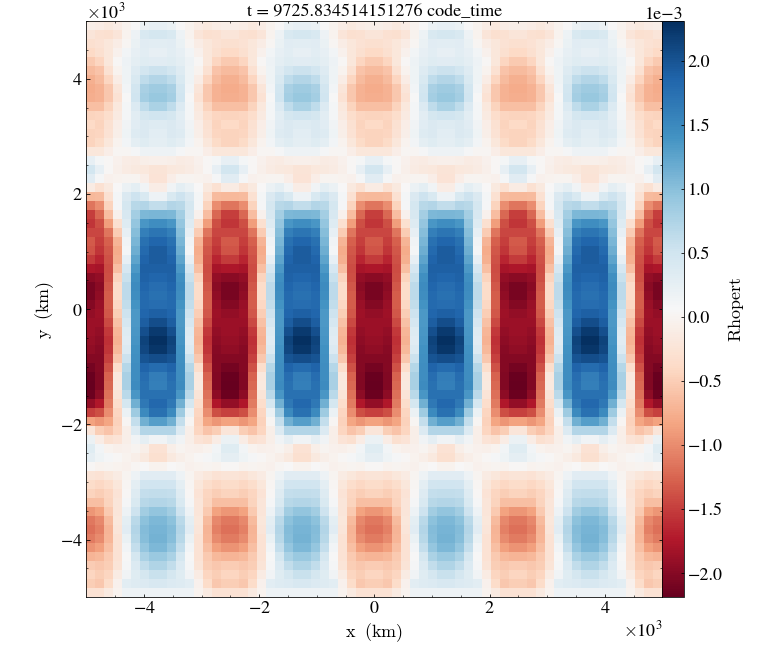


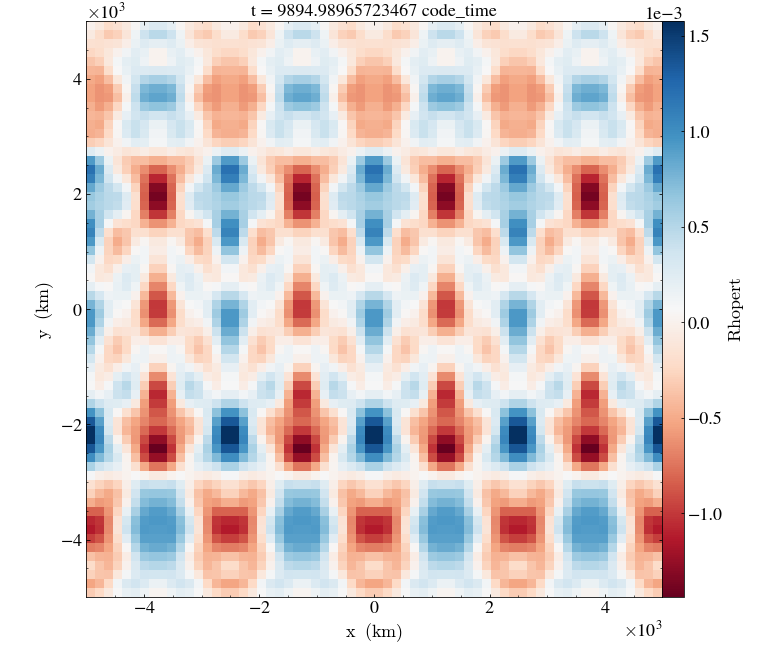


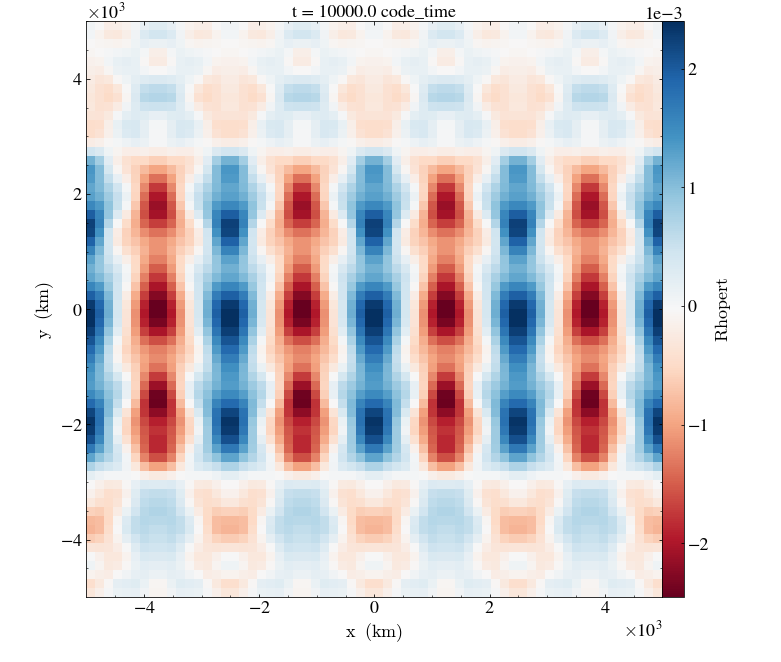

In [7]:

# Load data as a time series
ts = yt.load(dataDir+"/plt000????/") # I'd love a way to make this quiet

var = "rhopert";
filenum = 0
fileprefix='testout/'

for ds in ts:
    plot = yt.SlicePlot(ds, "z", var);
    plot.set_log(var, False);
    plot.set_cmap(field=var, cmap='RdBu')
    plot.annotate_title("t = {}".format(ds.current_time) )
    filenum = filenum + 1
    filename = "{}{:04}.png".format(fileprefix,filenum)
    plot.show()
    #plot.save(name=filename)


## Measured period at center of box

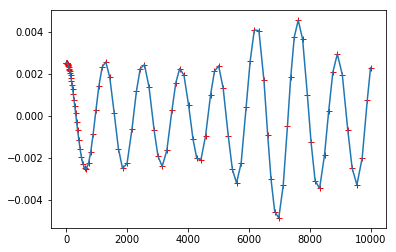

In [8]:
ts = yt.load(dataDir+"/plt000????/") # I'd love a way to make this quiet
pointdata  = []
time = []
for ds in ts:
    pointdata.append(ds.point([1e9/2,1e9/2,0.])['rhopert'].value[0])
    time.append(float(ds.current_time))
    
fig = plt.figure()
ax = plt.axes()
ax.plot(time, pointdata, '+r', time, pointdata)

## Comparison to a wave at the gravitational frequency

* red is measured
* blue is a wave with $\omega = N$
* green is a wave with  $\omega = \sqrt{2}N$

/data/njt132/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


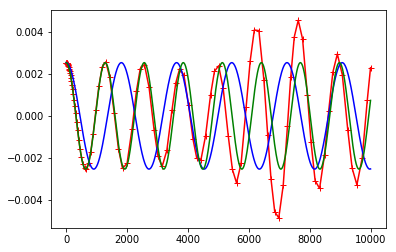

In [9]:
gamma = 5./3. 
g = 3e4
H = 1e9
N2 = (gamma-1.)/gamma * g / H

guess_w = np.sqrt(N2) 
smoothTime = np.linspace(0,1e4,1e3)
fig = plt.figure()
ax = plt.axes()
ax.plot(time, pointdata, '+r', time, pointdata, 'r',
        smoothTime, pointdata[0] * np.cos(-guess_w * smoothTime), 'b',
        smoothTime, pointdata[0] * np.cos(-guess_w*np.sqrt(2) * smoothTime), 'g')